In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import quilt3

from fish_morphology_code.analysis.notebook_utils import (
    DAY_18_COLOR,
    DAY_32_COLOR,
    DAY_COLOR_PALETTE,
    DAY_COLOR_PALETTE_THREE,
    BAR_PLOT_COLUMNS,
    SHORT_FEAT_NAME_MAP,
    BAR_PLOT_COLUMNS_SHORT,
    PROBE_ORDER,
    CI_EXTENT,
    FEATURE_TYPE_MAP,
    safe,
    get_regression_coef,
    boot_regression,
    ci_low,
    ci_high,
    make_reg_plot_ci_df,
    make_regression_bar_plot,
    get_pred_true,
    make_regression_scatter_plot,
    boot_spearmanr,
)

## plot config

In [2]:
SAVE=True

if SAVE:
    SAVE_DIR = Path("./plots_filtered")
    SAVE_DIR.mkdir(parents=True, exist_ok=True)

    save_dir_pngs = SAVE_DIR/"pngs"
    save_dir_svgs = SAVE_DIR/"svgs"
    save_dir_pngs.mkdir(parents=True, exist_ok=True)
    save_dir_svgs.mkdir(parents=True, exist_ok=True)

    fig4_supp_dir_pngs = save_dir_pngs/"fig4_supp"
    fig4_supp_dir_svgs = save_dir_svgs/"fig4_supp"
    fig4_supp_dir_pngs.mkdir(parents=True, exist_ok=True)
    fig4_supp_dir_svgs.mkdir(parents=True, exist_ok=True)

    regression_sup_dir_pngs = save_dir_pngs/"regression_supp"
    regression_sup_dir_svgs = save_dir_svgs/"regression_supp"
    regression_sup_dir_pngs.mkdir(parents=True, exist_ok=True)
    regression_sup_dir_svgs.mkdir(parents=True, exist_ok=True)

## load data

In [3]:
p = quilt3.Package.browse(
    "aics/integrated_transcriptomics_structural_organization_hipsc_cm",
    "s3://allencell",
)

Loading manifest: 100%|██████████| 8430/8430 [00:00<00:00, 27200.12entries/s]


### FISH

In [4]:
# df = p["manuscript_plots"]["data.csv"]()
from fish_morphology_code.analysis.collate_plot_dataset import collate_plot_dataset

df = collate_plot_dataset()

Loading manifest: 100%|██████████| 5/5 [00:00<00:00, 3302.60entries/s]
100%|██████████| 119M/119M [00:42<00:00, 2.81MB/s] 
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarni

### scRNA-seq

In [5]:
df_rnaseq = p["manuscript_plots"]["data_rnaseq.csv"]()

### make tidy version of FISH data

In [6]:
PROBE_ORDER = [
    "MYH6",
    "MYH7",
    "COL2A1",
    "H19",
    "TCAP",
    "ATP2A2",
    "BAG3",
    "HPRT1",
    "BMPER",
    "CNTN5",
    "MEF2C",
    "MYL7",
    "NKX2",
    "PLN",
    "PRSS35",
    "VCAN",
]

In [7]:
melt_feats = {
    "count" : [
        'HPRT1 count',
        'COL2A1 count',
        'H19 count',
        'ATP2A2 count',
        'MYH6 count',
        'MYH7 count',
        'BAG3 count',
        'TCAP count',
        'BMPER count',
        'CNTN5 count',
        'MEF2C count',
        'MYL7 count',
        'NKX2 count',
        'PLN count',
        'PRSS35 count',
        'VCAN count',
    ],
    "(count/μm^2)" : [
        'HPRT1 (count/μm^2)',
        'COL2A1 (count/μm^2)',
        'H19 (count/μm^2)',
        'ATP2A2 (count/μm^2)',
        'MYH6 (count/μm^2)',
        'MYH7 (count/μm^2)',
        'BAG3 (count/μm^2)',
        'TCAP (count/μm^2)',
        'BMPER (count/μm^2)',
        'CNTN5 (count/μm^2)',
        'MEF2C (count/μm^2)',
        'MYL7 (count/μm^2)',
        'NKX2 (count/μm^2)',
        'PLN (count/μm^2)',
        'PRSS35 (count/μm^2)',
        'VCAN (count/μm^2)',
    ]
}

melted_dfs = {
    feat:df.melt(
        id_vars=[c for c in df.columns if c not in cols],
        value_vars=cols,
        var_name="FISH probe",
        value_name=f"FISH probe {feat}",
    ).dropna(
        subset=[f"FISH probe {feat}"]
    ).reset_index(
        drop=True
    )
    for feat, cols in melt_feats.items()
}

for feat,v in melted_dfs.items():
    melted_dfs[feat]["FISH probe"] = melted_dfs[feat]["FISH probe"].str.split().str.get(0)
    
df_tidy = melted_dfs['count'].merge(
    melted_dfs["(count/μm^2)"]
).drop(
    columns=melt_feats['count']+melt_feats["(count/μm^2)"]
)

### make version that counts both human scores

In [8]:
melt_cols = [
        'Expert structural annotation score (annotator 1)',
        'Expert structural annotation score (annotator 2)',
    ]

keep_cols = [
        'Cell number',
        'FOV path',
        'Cell age',
        'Combined organizational score',
        "Combined organizational score (rounded)",
        'Alpha-actinin intensity (median, normalized per day)',
    ]

df_org_scores_all = df[melt_cols+keep_cols].melt(
    id_vars=keep_cols,
    value_vars=melt_cols,
    var_name="Score origin",
    value_name="Expert structural annotation score (all)",
)

df_org_scores_all = df_org_scores_all.dropna(subset=["Expert structural annotation score (all)"])

## summary table

In [9]:
df_tidy.groupby(
    ["Cell age", "Expert structural annotation score (grouped)"]
).size().reset_index().rename(columns={0:'Count'})

Cell age Expert structural annotation score (grouped)  Count
0        18                                          1-2    944
1        18                                            3   3508
2        18                                          4-5    912
3        32                                          1-2    198
4        32                                            3   1788
5        32                                          4-5   2116

In [10]:
len(df[['Cell number', 'FOV path']].drop_duplicates())

10537

In [11]:
len(df[['FOV path']].drop_duplicates())

1036

In [12]:
df.groupby(
    ["Cell age"]
).size().reset_index().rename(columns={0:'Count'})

Cell age  Count
0        18   5884
1        32   4653

In [13]:
df_tidy.groupby(
    ["FISH probe"]
).size().reset_index().rename(columns={0:'Count'})

FISH probe  Count
0      ATP2A2   1147
1        BAG3   1130
2       BMPER   1505
3       CNTN5   1388
4      COL2A1   1179
5         H19   1147
6       HPRT1   1179
7       MEF2C   1435
8        MYH6   1277
9        MYH7   1277
10       MYL7   1435
11       NKX2   1388
12        PLN   1476
13     PRSS35   1476
14       TCAP   1130
15       VCAN   1505

In [14]:
df_tidy.groupby(
    ["FISH probe", "Cell age"]
).size().reset_index().rename(columns={0:'Count'})

FISH probe  Cell age  Count
0      ATP2A2        18    634
1      ATP2A2        32    513
2        BAG3        18    634
3        BAG3        32    496
4       BMPER        18    791
5       BMPER        32    714
6       CNTN5        18    744
7       CNTN5        32    644
8      COL2A1        18    704
9      COL2A1        32    475
10        H19        18    634
11        H19        32    513
12      HPRT1        18    704
13      HPRT1        32    475
14      MEF2C        18    830
15      MEF2C        32    605
16       MYH6        18    710
17       MYH6        32    567
18       MYH7        18    710
19       MYH7        32    567
20       MYL7        18    830
21       MYL7        32    605
22       NKX2        18    744
23       NKX2        32    644
24        PLN        18    837
25        PLN        32    639
26     PRSS35        18    837
27     PRSS35        32    639
28       TCAP        18    634
29       TCAP        32    496
30       VCAN        18    791
31       VCAN        32    714

In [15]:
df_tidy[["FOV path", "FISH probe"]].drop_duplicates().groupby(
    ["FISH probe"]
).size().reset_index().rename(columns={0:'Count'})

FISH probe  Count
0      ATP2A2    120
1        BAG3    120
2       BMPER    140
3       CNTN5    140
4      COL2A1    118
5         H19    120
6       HPRT1    118
7       MEF2C    140
8        MYH6    118
9        MYH7    118
10       MYL7    140
11       NKX2    140
12        PLN    140
13     PRSS35    140
14       TCAP    120
15       VCAN    140

## 2c

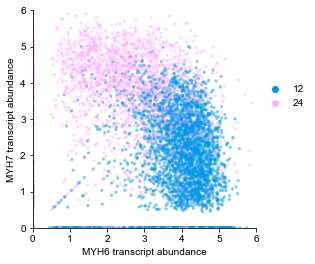

In [16]:
plt.figure(figsize=(4, 4))

plot_67_seq = sns.scatterplot(
    data=df_rnaseq,
    x="MYH6 expression",
    y="MYH7 expression",
    hue="Cell age",
    hue_order=[12, 24],
    palette=DAY_COLOR_PALETTE,
    linewidth=0,
    alpha = 0.5,
    s=10
)

plot_67_seq.set(
    xlim=(0, 6),
    ylim=(0, 6),
    xlabel="MYH6 transcript abundance",
    ylabel="MYH7 transcript abundance",
)


plt.legend(bbox_to_anchor=(1.0, 0.7), frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_2c_rnaseq_scatter.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_2c_rnaseq_scatter.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

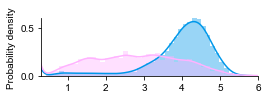

In [17]:
bins = np.linspace(0,6,51)
bins -= (bins[1]-bins[0])/2

g = sns.FacetGrid(
    data=df_rnaseq,
    hue="Cell age",
    hue_order=[12, 24],
    palette=DAY_COLOR_PALETTE,
    height=1.5,
    aspect=2.33,
)
g = g.map(
    sns.distplot,
    "MYH6 expression",
    bins=bins,
    kde_kws=dict(bw=0.1)
)
g.set(xlabel='', ylabel='Probability density')
g.set(xlim=(0.3, 6));
g.set(ylim=(0, 0.6));

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_2c_rnaseq_MYH6_hist_main.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_2c_rnaseq_MYH6_hist_main.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


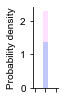

In [18]:
bins = np.linspace(0,6,51)
bins -= (bins[1]-bins[0])/2

g = sns.FacetGrid(
    data=df_rnaseq,
    hue="Cell age",
    hue_order=[12, 24],
    palette=DAY_COLOR_PALETTE,
    height=1.5,
    aspect=0.3,
)
g = g.map(
    sns.distplot,
    "MYH6 expression",
    bins=bins,
    kde=False,
    norm_hist=True,
)
g.set(xlabel='', ylabel='Probability density')
g.set(xlim=(-0.3, 0.3));
g.set(ylim=(0, None));
g.set(xticklabels=[]);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_2c_rnaseq_MYH6_hist_zeros.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_2c_rnaseq_MYH6_hist_zeros.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

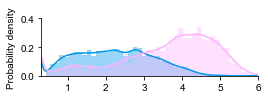

In [19]:
bins = np.linspace(0,6,51)
bins -= (bins[1]-bins[0])/2

g = sns.FacetGrid(
    data=df_rnaseq,
    hue="Cell age",
    hue_order=[12, 24],
    palette=DAY_COLOR_PALETTE,
    height=1.5,
    aspect=2.33,
)
g = g.map(
    sns.distplot,
    "MYH7 expression",
    bins=bins,
    kde_kws=dict(bw=.1),
)
g.set(xlabel='', ylabel='Probability density')
g.set(xlim=(0.3, 6));
g.set(ylim=(0, 0.4));

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_2c_rnaseq_MYH7_hist_main.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_2c_rnaseq_MYH7_hist_main.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


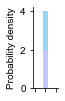

In [20]:
bins = np.linspace(0,6,51)
bins -= (bins[1]-bins[0])/2

g = sns.FacetGrid(
    data=df_rnaseq,
    hue="Cell age",
    hue_order=[12, 24],
    palette=DAY_COLOR_PALETTE,
    height=1.5,
    aspect=0.3,
)
g = g.map(
    sns.distplot,
    "MYH7 expression",
    bins=bins,
    kde=False,
    norm_hist=True,

)
g.set(xlabel='', ylabel='Probability density')
g.set(xlim=(-0.3, 0.3));
g.set(ylim=(0, None));
g.set(xticklabels=[]);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_2c_rnaseq_MYH7_hist_zeros.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_2c_rnaseq_MYH7_hist_zeros.svg', format="svg", bbox_inches = "tight")

## 3c score histogram

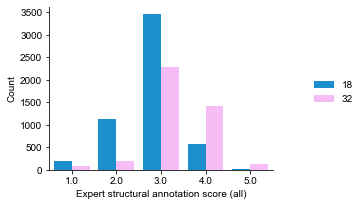

In [21]:
plt.figure(figsize=(4, 3))

plot_3c = sns.countplot(
    data=df_org_scores_all,
    x="Expert structural annotation score (all)",
    hue="Cell age",
    palette=DAY_COLOR_PALETTE,
)

plot_3c.set(ylabel='Count');

sns.despine()
plt.legend(bbox_to_anchor=(1.4, 0.6),frameon=False)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_3c_expert_annotations_hist.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_3c_expert_annotations_hist.svg', format="svg", bbox_inches = "tight")

## 3d median intensity by annotation class

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 22.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


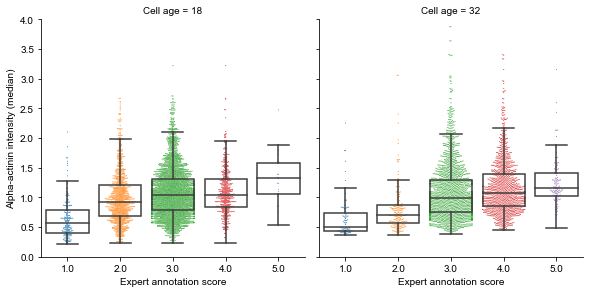

In [22]:
g = sns.catplot(
    data=df_org_scores_all,
    x='Expert structural annotation score (all)',
    y='Alpha-actinin intensity (median, normalized per day)',
    hue='Expert structural annotation score (all)',
    hue_order=[1,2,3,4,5],
    s=1,
    col="Cell age",
    kind="swarm",
    height=4,
    aspect=1.0,
    zorder=0
);

g.set_titles("Cell age = {col_name}")  # use this argument literally

axes=g.axes[0]

for i, cell_age in enumerate(sorted(df["Cell age"].unique())):

    h = sns.boxplot(
        data=df_org_scores_all[df_org_scores_all["Cell age"]==cell_age],
        x='Expert structural annotation score (all)',
        y='Alpha-actinin intensity (median, normalized per day)',
        showcaps=True,
        boxprops={'facecolor':'None'},
        showfliers=False,
        ax=axes[i]
    )
    
    h.set(
        xlabel='Expert annotation score',
        ylabel='Alpha-actinin intensity (median)'
    )
    
    if i > 0:
        h.set(
        ylabel=''
    )

axes = g.axes[0];
axes[0].set_ylim(0, 4);
axes[1].set_ylim(0, 4);

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_3d_intensity_vs_expert_score_swarmbox_by_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_3d_intensity_vs_expert_score_swarmbox_by_day.svg', format="svg", bbox_inches = "tight")

## 3 supp

In [105]:
ecols = [
    'Expert structural annotation score (annotator 2)',
    'Expert structural annotation score (annotator 1)'
]
df.dropna(subset=ecols)[ecols].corr(method="spearman")

Expert structural annotation score (annotator 2)  \
Expert structural annotation score (annotator 2)                                          1.000000   
Expert structural annotation score (annotator 1)                                          0.650497   

                                                  Expert structural annotation score (annotator 1)  
Expert structural annotation score (annotator 2)                                          0.650497  
Expert structural annotation score (annotator 1)                                          1.000000

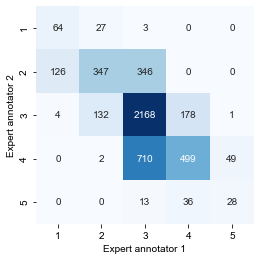

In [23]:
from sklearn.metrics import confusion_matrix

df_3supp_dropna = df.dropna(subset=['Expert structural annotation score (annotator 2)', 'Expert structural annotation score (annotator 1)'])

conf_mat = confusion_matrix(df_3supp_dropna['Expert structural annotation score (annotator 2)'], df_3supp_dropna['Expert structural annotation score (annotator 1)'])

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
conf_mat_plot = sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    square=True,
    cmap="Blues",
    vmin=0,
    vmax=1000,
    cbar=False,
)

conf_mat_plot.set(
    xlabel='Expert annotator 1',
    ylabel='Expert annotator 2'
);
conf_mat_plot.set_xticklabels([1,2,3,4,5])
conf_mat_plot.set_yticklabels([1,2,3,4,5]);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_3supp_expert_annotations_confmat.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_3supp_expert_annotations_confmat.svg', format="svg", bbox_inches = "tight")

## 3g stripes vs global alignment

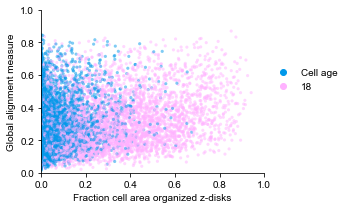

In [24]:
plt.figure(figsize=(4, 3))

plot_org_vs_stripes = sns.scatterplot(
    data=df.sample(frac=1, replace=False).reset_index(drop=True),
    x="Fraction cell area organized z-disks",
    y="Max coefficient var",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    linewidth=0,
    alpha = 0.5,
    s=10,
)
plot_org_vs_stripes.set(ylabel="Global alignment measure");
plot_org_vs_stripes.set(xlim=(0, 1));
plot_org_vs_stripes.set(ylim=(0, 1));

handles, _ = plot_org_vs_stripes.get_legend_handles_labels()
plot_org_vs_stripes.legend(handles, ["Cell age", "18", "32"], bbox_to_anchor=(1.0, 0.7), frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_3g_regular_stripes_vs_global_alignment.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_3g_regular_stripes_vs_global_alignment.svg', format="svg", bbox_inches = "tight")

## 4b regression coefs

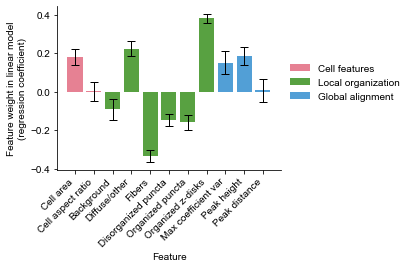

In [25]:
df_boot_reg = boot_regression(
    df[df["Experiment Round"] == 1],
    N=1000,
    X_cols=BAR_PLOT_COLUMNS,
    y_col="Expert structural annotation score (mean)",
    weight_col="Expert structural annotation score (mean)",
)

reg_plot_ci_df = make_reg_plot_ci_df(df_boot_reg)

fig_bar, ax_bar = make_regression_bar_plot(reg_plot_ci_df, title="")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4b_linear_model_feature_importances.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4b_linear_model_feature_importances.svg', format="svg", bbox_inches = "tight")

## 4c expert score vs linear model

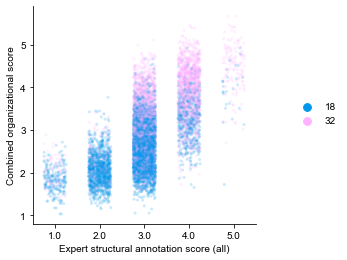

In [26]:
dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)

g = sns.stripplot(
    data=df_org_scores_all.sample(frac=1, replace=False).reset_index(drop=True),
    x="Expert structural annotation score (all)",
    y="Combined organizational score",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    alpha=0.2,
    linewidth=0,
    jitter=0.25,
    s=3
)

sns.despine()
plt.legend(bbox_to_anchor=(1.4, 0.6),frameon=False)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4c_linear_model_pred_vs_true.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4c_linear_model_pred_vs_true.svg', format="svg", bbox_inches = "tight")

# 4 supp confusion matrices for linear model

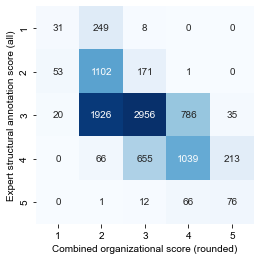

In [27]:
conf_mat_all = confusion_matrix(df_org_scores_all['Expert structural annotation score (all)'], df_org_scores_all['Combined organizational score (rounded)'])

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
conf_mat_plot_all = sns.heatmap(
    conf_mat_all,
    annot=True,
    fmt="d",
    square=True,
    cmap="Blues",
    vmin=0,
    vmax=2000,
    cbar=False,
)

conf_mat_plot_all.set(
    xlabel='Combined organizational score (rounded)',
    ylabel='Expert structural annotation score (all)'
);
conf_mat_plot_all.set_xticklabels([1,2,3,4,5])
conf_mat_plot_all.set_yticklabels([1,2,3,4,5]);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4supp_linear_model_conf_mat_vs_both.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4supp_linear_model_conf_mat_vs_both.svg', format="svg", bbox_inches = "tight")

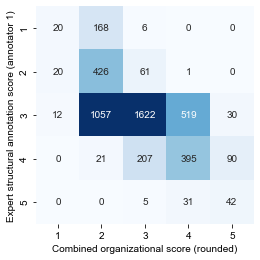

In [28]:
df_supp4 = df.dropna(subset=['Expert structural annotation score (annotator 1)','Combined organizational score (rounded)'])
conf_mat_ann_1 = confusion_matrix(df_supp4['Expert structural annotation score (annotator 1)'], df_supp4['Combined organizational score (rounded)'])

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
conf_mat_plot_ann_1 = sns.heatmap(
    conf_mat_ann_1,
    annot=True,
    fmt="d",
    square=True,
    cmap="Blues",
    vmin=0,
    vmax=1000,
    cbar=False,
)

conf_mat_plot_ann_1.set(
    xlabel='Combined organizational score (rounded)',
    ylabel='Expert structural annotation score (annotator 1)'
);
conf_mat_plot_ann_1.set_xticklabels([1,2,3,4,5])
conf_mat_plot_ann_1.set_yticklabels([1,2,3,4,5]);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4supp_linear_model_conf_mat_vs_ann_1.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4supp_linear_model_conf_mat_vs_ann_1.svg', format="svg", bbox_inches = "tight")

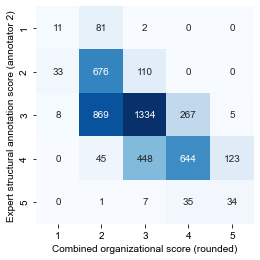

In [29]:
conf_mat_ann_2 = confusion_matrix(df_supp4['Expert structural annotation score (annotator 2)'], df_supp4['Combined organizational score (rounded)'])

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
conf_mat_plot_ann_2 = sns.heatmap(
    conf_mat_ann_2,
    annot=True,
    fmt="d",
    square=True,
    cmap="Blues",
    vmin=0,
    vmax=1000,
    cbar=False,
)

conf_mat_plot_ann_2.set(
    xlabel='Combined organizational score (rounded)',
    ylabel='Expert structural annotation score (annotator 2)'
);
conf_mat_plot_ann_2.set_xticklabels([1,2,3,4,5])
conf_mat_plot_ann_2.set_yticklabels([1,2,3,4,5]);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4supp_linear_model_conf_mat_vs_ann_2.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4supp_linear_model_conf_mat_vs_ann_2.svg', format="svg", bbox_inches = "tight")

## 4e

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

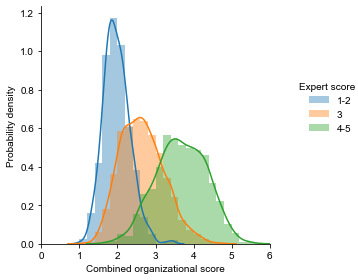

In [30]:
bins = np.linspace(0,6,31)

g = sns.FacetGrid(
    df,
    hue='Expert structural annotation score (grouped)',
    hue_order=["1-2", "3", "4-5"],
    height=4
)
g = g.map(
    sns.distplot,
    'Combined organizational score',
    bins=bins
).add_legend()

g.set(xlim=(0, 6));
g._legend.set(bbox_to_anchor=(0.75, 0.6))
g._legend.set_title("Expert score  ")
g.set(ylabel='Probability density');

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4e_linear_model_distplot_grouped_by_human_score.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4e_linear_model_distplot_grouped_by_human_score.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

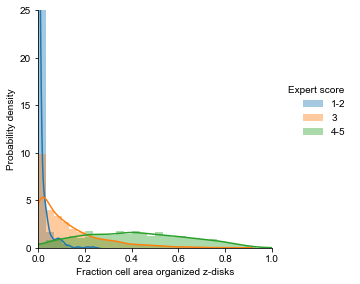

In [31]:
bins = np.linspace(0,1,31)

g = sns.FacetGrid(
    df,
    hue="Expert structural annotation score (grouped)",
    hue_order=["1-2", "3", "4-5"],
    height=4
)
g = g.map(
    sns.distplot,
    'Fraction cell area organized z-disks',
    bins=bins,
).add_legend()

g.set(xlim=(0, 1));
g.set(ylim=(0, 25));
g._legend.set(bbox_to_anchor=(0.75, 0.6))
g._legend.set_title("Expert score      ")

g.set(ylabel='Probability density');

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4e_regular_stripes_distplot_grouped_by_human_score.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4e_regular_stripes_distplot_grouped_by_human_score.svg', format="svg", bbox_inches = "tight")

## 4f

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


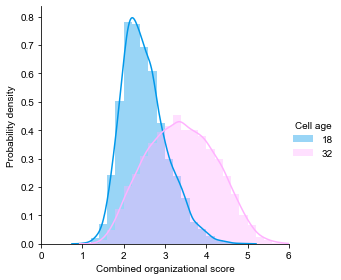

In [32]:
bins = np.linspace(0,6,31)

g = sns.FacetGrid(
    df,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=4
)
g = g.map(
    sns.distplot,
    'Combined organizational score',
    bins=bins
).add_legend()

g.set(
    xlim=(0, 6),
    ylabel='Probability density'
);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4f_linear_model_distplot_grouped_by_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4f_linear_model_distplot_grouped_by_day.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


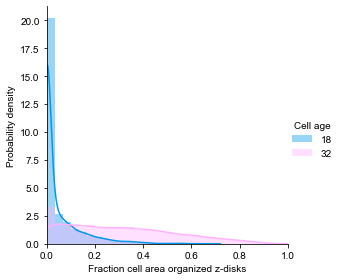

In [33]:
bins = np.linspace(0,1,31)

g = sns.FacetGrid(
    df,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=4
)
g = g.map(
    sns.distplot,
    "Fraction cell area organized z-disks",
    bins=bins
).add_legend()

g.set(
    xlim=(0, 1),
    ylabel='Probability density'
);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4f_regular_stripes_distplot_grouped_by_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4f_regular_stripes_distplot_grouped_by_day.svg', format="svg", bbox_inches = "tight")

## 4 supp

In [34]:
lim_map={
    'Cell area (μm^2)': (0.0, 10_000),
    'Cell aspect ratio': (0.0, 1.0),
    'Fraction cell area background': (0.0, 1.0),
    'Fraction cell area diffuse/other': (0.0, 1.0),
    'Fraction cell area fibers': (0.0, 1.0),
    'Fraction cell area disorganized puncta': (0.0, 1.0),
    'Fraction cell area organized puncta': (0.0, 1.0),
    'Fraction cell area organized z-disks': (0.0, 1.0),
    'Max coefficient var': (0.0, 1.0),
    'Peak height': (0.0, 1.0),
    'Peak distance (μm)': (0.5, 3.0),
}

In [35]:
for feature in BAR_PLOT_COLUMNS:

    bins = np.linspace(0,lim_map[feature][1],21)
    print(bins[-1]/len(bins))

476.1904761904762
0.047619047619047616
0.047619047619047616
0.047619047619047616
0.047619047619047616
0.047619047619047616
0.047619047619047616
0.047619047619047616
0.047619047619047616
0.047619047619047616
0.14285714285714285


/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

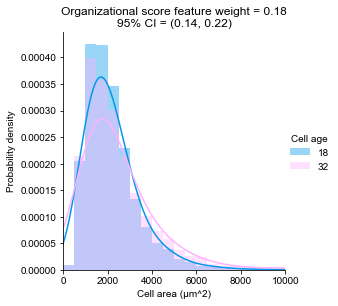

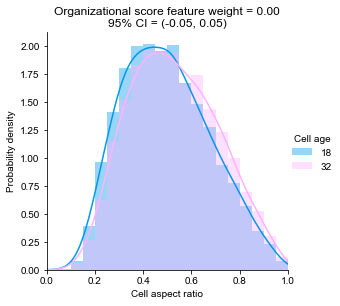

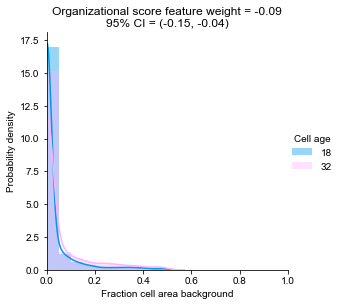

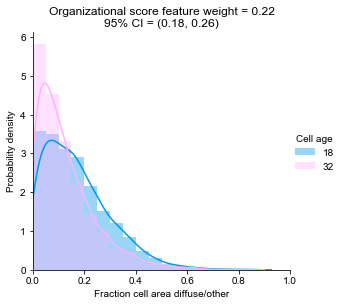

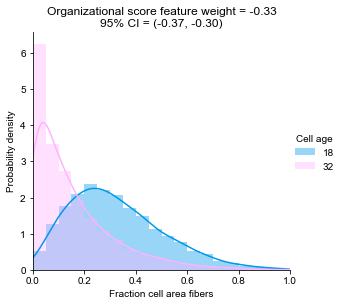

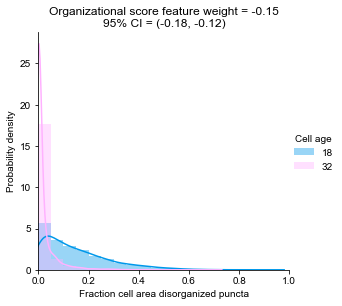

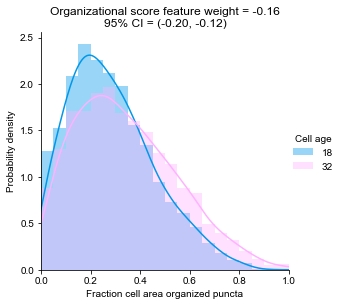

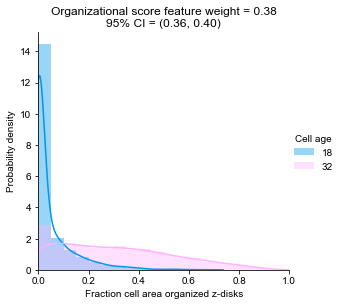

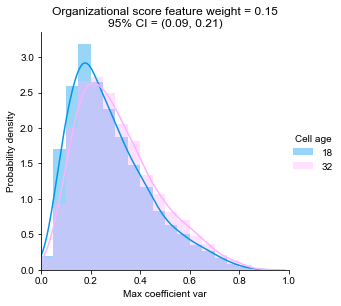

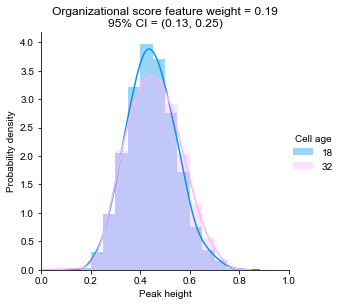

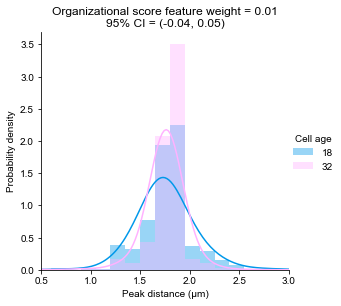

In [36]:
for feature in BAR_PLOT_COLUMNS:

    bins = np.linspace(0,lim_map[feature][1],21)
    
    g = sns.FacetGrid(
        df,
        hue="Cell age",
        hue_order=[18, 32],
        palette=DAY_COLOR_PALETTE,
        height=4
    );
    g = g.map(
        sns.distplot,
        feature,
        bins=bins,
        kde=True,
        kde_kws=dict(bw_method=bins[-1]/len(bins) if feature!='Cell area (μm^2)' else 0.1, bw_adjust=5)
    ).add_legend();
    
    row = reg_plot_ci_df[reg_plot_ci_df["Feature"]==feature].iloc[0,:]
    title = f'Organizational score feature weight = {row["Feature weight (mean)"]:.2f}\n95% CI = ({row["Feature weight (CI low)"]:.2f}, {row["Feature weight (CI high)"]:.2f})'
    
    g.set(
        xlim=lim_map[feature],
        xlabel=feature,
        ylabel='Probability density',
        title=title,
    );

    g._legend.set_title("Cell age");
    
    # save png and svg
    if SAVE:
        plt.savefig(fig4_supp_dir_pngs/f'fig_4supp_{safe(feature)}_distplot_grouped_by_day.png', dpi=100, bbox_inches = "tight");
        plt.savefig(fig4_supp_dir_svgs/f'fig4_supp_{safe(feature)}_distplot_grouped_by_day.svg', format="svg", bbox_inches = "tight");

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

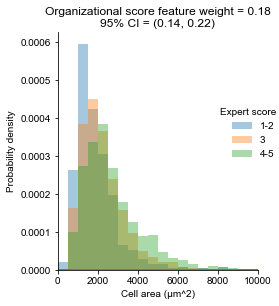

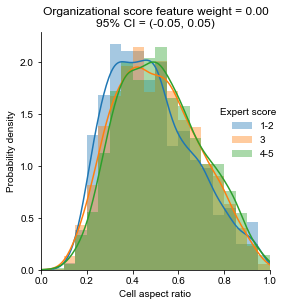

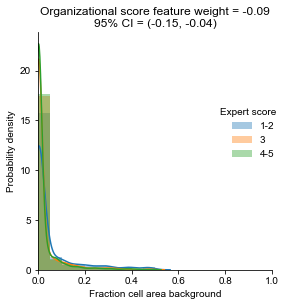

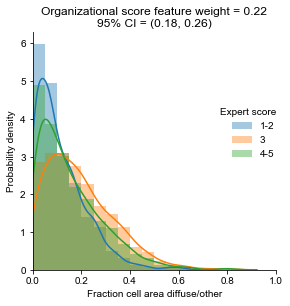

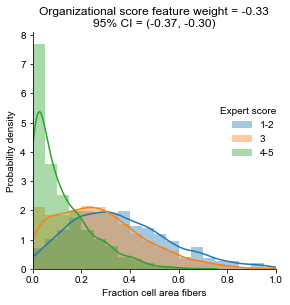

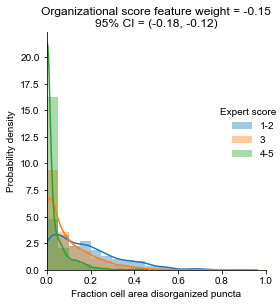

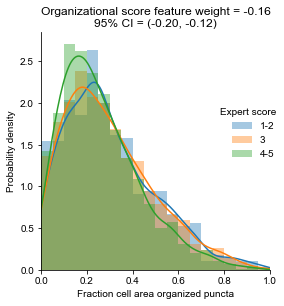

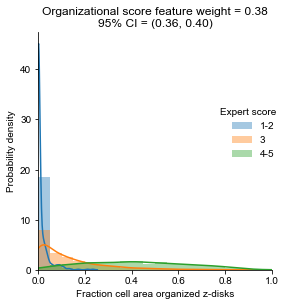

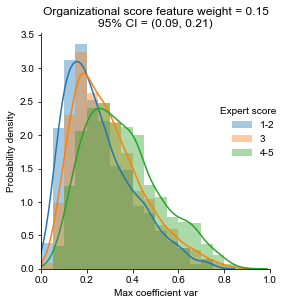

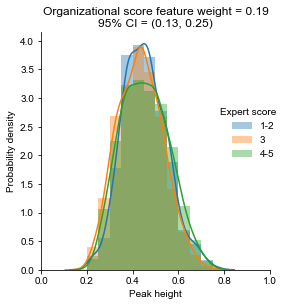

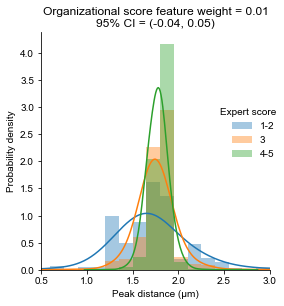

In [37]:
for feature in BAR_PLOT_COLUMNS:

    bins = np.linspace(0,lim_map[feature][1],21)

    g = sns.FacetGrid(
        df,
        hue='Expert structural annotation score (grouped)',
        hue_order=["1-2", "3", "4-5"],
        height=4
    );
    g = g.map(
        sns.distplot,
        feature,
        bins=bins,
        kde_kws=dict(bw_method=bins[-1]/len(bins), bw_adjust=5)
    ).add_legend();

    row = reg_plot_ci_df[reg_plot_ci_df["Feature"]==feature].iloc[0,:]
    title = f'Organizational score feature weight = {row["Feature weight (mean)"]:.2f}\n95% CI = ({row["Feature weight (CI low)"]:.2f}, {row["Feature weight (CI high)"]:.2f})'
    
    g.set(
        xlim=lim_map[feature],
        xlabel=feature.replace("_", " ").capitalize(),
        ylabel='Probability density',
        title=title
    );
    g._legend.set(bbox_to_anchor=(0.6, 0.6))
    g._legend.set_title("Expert score    ")

    # save png and svg
    if SAVE:
        plt.savefig(fig4_supp_dir_pngs/f'fig_4supp_{safe(feature)}_distplot_grouped_by_human_score.png', dpi=100, bbox_inches = "tight");
        plt.savefig(fig4_supp_dir_svgs/f'fig_4supp_{safe(feature)}_distplot_grouped_by_human_score.svg', format="svg", bbox_inches = "tight");

## 4 g

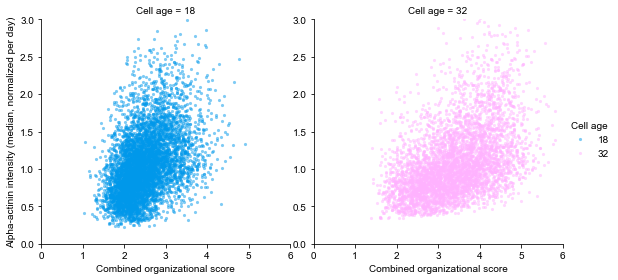

In [38]:
g = sns.FacetGrid(
    df,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=4,
    aspect=1,
    col="Cell age",
    sharey=False,
)
g = g.map(
    sns.scatterplot,
    "Combined organizational score",
    "Alpha-actinin intensity (median, normalized per day)",
    linewidth=0,
    alpha = 0.5,
    s=10,
).add_legend(title='Cell age')

axes = g.axes[0];
axes[0].set_ylim(0, 3);
axes[1].set_ylim(0, 3);
axes[0].set_xlim(0, 6);
axes[1].set_xlim(0, 6);

g.set_titles("Cell age = {col_name}")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4g_linear_model_org_vs_actn2_medain_intensity.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4g_linear_model_org_vs_actn2_medain_intensity.svg', format="svg", bbox_inches = "tight")

In [39]:
x='Combined organizational score'
y='Alpha-actinin intensity (median, normalized per day)'
stratify='Cell age'

df_int_org_corr = boot_spearmanr(df, x=x, y=y, stratify=stratify, N=1000)

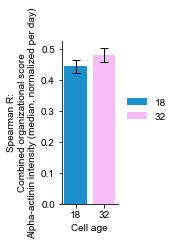

In [40]:
dims = (1, 3)
fig, ax = plt.subplots(figsize=dims)

bar_order = ["18", "32"]

feat_chart = sns.barplot(
    data=df_int_org_corr,
    x=stratify,
    order=bar_order,
    y=f"Spearman R ({x}, {y}) (mean)",
    hue=stratify,
    palette=DAY_COLOR_PALETTE,
    dodge=False
);

mean_col = f"Spearman R ({x}, {y}) (mean)"
hi_col = f"Spearman R ({x}, {y}) (CI high)"
low_col = f"Spearman R ({x}, {y}) (CI low)"

err = np.array(((df_int_org_corr[mean_col] - df_int_org_corr[low_col]).values,
                (df_int_org_corr[hi_col] - df_int_org_corr[mean_col]).values))

plt.errorbar(
    x=df_int_org_corr.set_index(stratify).loc[bar_order,:].reset_index()[stratify],
    y=df_int_org_corr.set_index(stratify).loc[bar_order,:].reset_index()[mean_col],
    fmt='none',
    yerr=err,
    ecolor='k',
    elinewidth=1,
    capsize=4
)

sns.despine();

# feat_chart.set_xticklabels(feat_chart.get_xticklabels(), rotation=45, horizontalalignment='right');
feat_chart.set(
    xlabel=stratify,
    ylabel=f"Spearman R:\n{x}\n{y}"
);
plt.legend(bbox_to_anchor=(1.0, 0.7), frameon=False);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4g_linear_model_org_vs_actn2_median_intensity_corr.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4g_linear_model_org_vs_actn2_median_intensity_corr.svg', format="svg", bbox_inches = "tight")

## 5a probe density vs structure

In [109]:
# df_tidy.columns

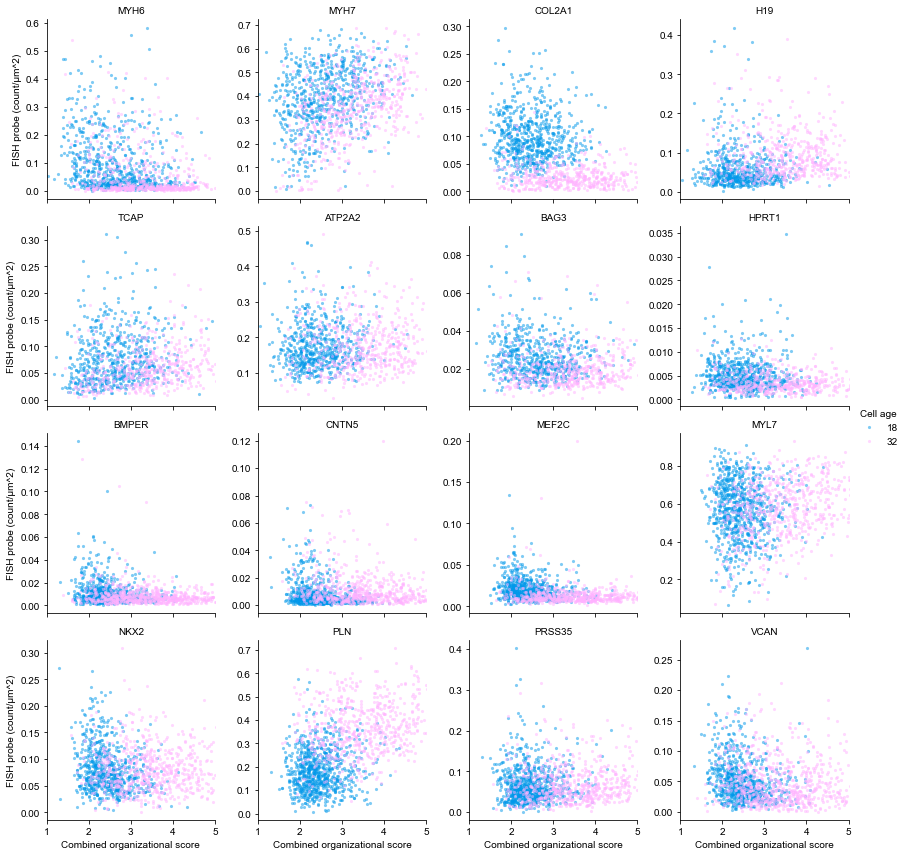

In [41]:
g = sns.FacetGrid(
    data=df_tidy.sample(frac=1, replace=False).reset_index(drop=True),
    col="FISH probe",
    col_order=PROBE_ORDER,
    col_wrap=4,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    sharex=True,
    xlim=(1,5),
    sharey=False,
    height=3.0,
    aspect=1.0,
)

g = g.map(
    plt.scatter,
    "Combined organizational score",
    "FISH probe (count/μm^2)",
    s=10,
    alpha=0.5,
    linewidth=0,
).add_legend()

g.set_titles("{col_name}")

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5a_probe_density_vs_org_score.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5a_probe_density_vs_org_score.svg', format="svg", bbox_inches = "tight")

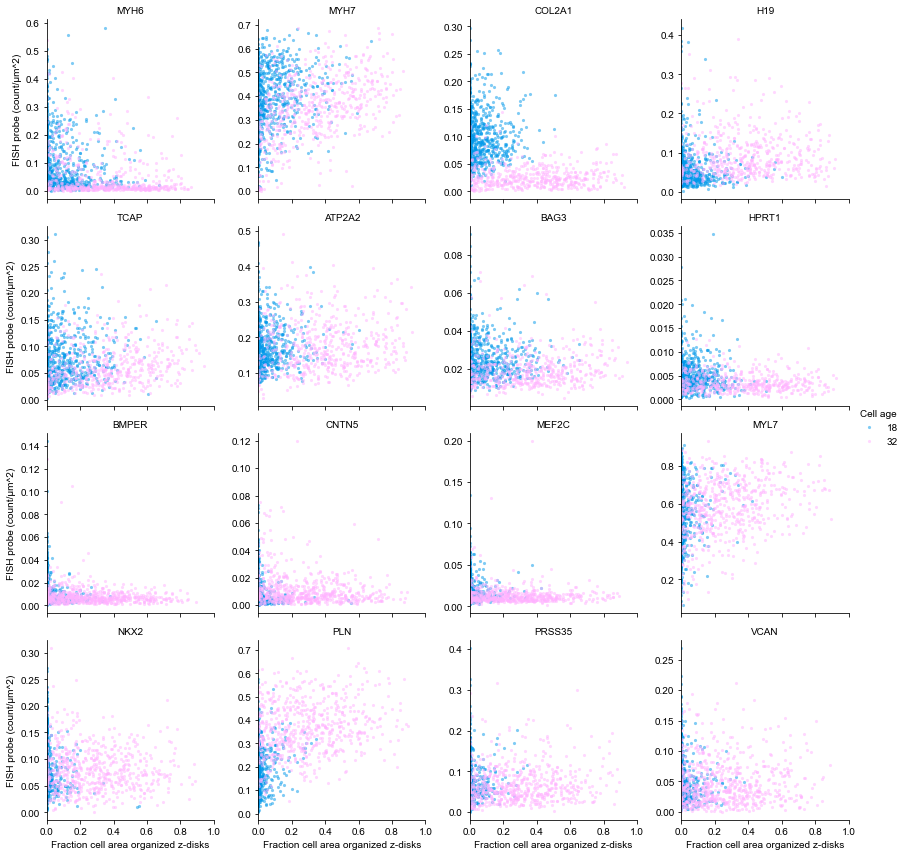

In [112]:
g = sns.FacetGrid(
    data=df_tidy.sample(frac=1, replace=False).reset_index(drop=True),
    col="FISH probe",
    col_order=PROBE_ORDER,
    col_wrap=4,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    sharex=True,
    xlim=(0,1),
    sharey=False,
    height=3.0,
    aspect=1.0,
)

g = g.map(
    plt.scatter,
    'Fraction cell area organized z-disks',
    "FISH probe (count/μm^2)",
    s=10,
    alpha=0.5,
    linewidth=0,
).add_legend()

g.set_titles("{col_name}")

sns.despine()

# save png and svg
# if SAVE:
#     plt.savefig(save_dir_pngs/'fig_5a_probe_density_vs_org_score.png', dpi=100, bbox_inches = "tight")
#     plt.savefig(save_dir_svgs/'fig_5a_probe_density_vs_org_score.svg', format="svg", bbox_inches = "tight")

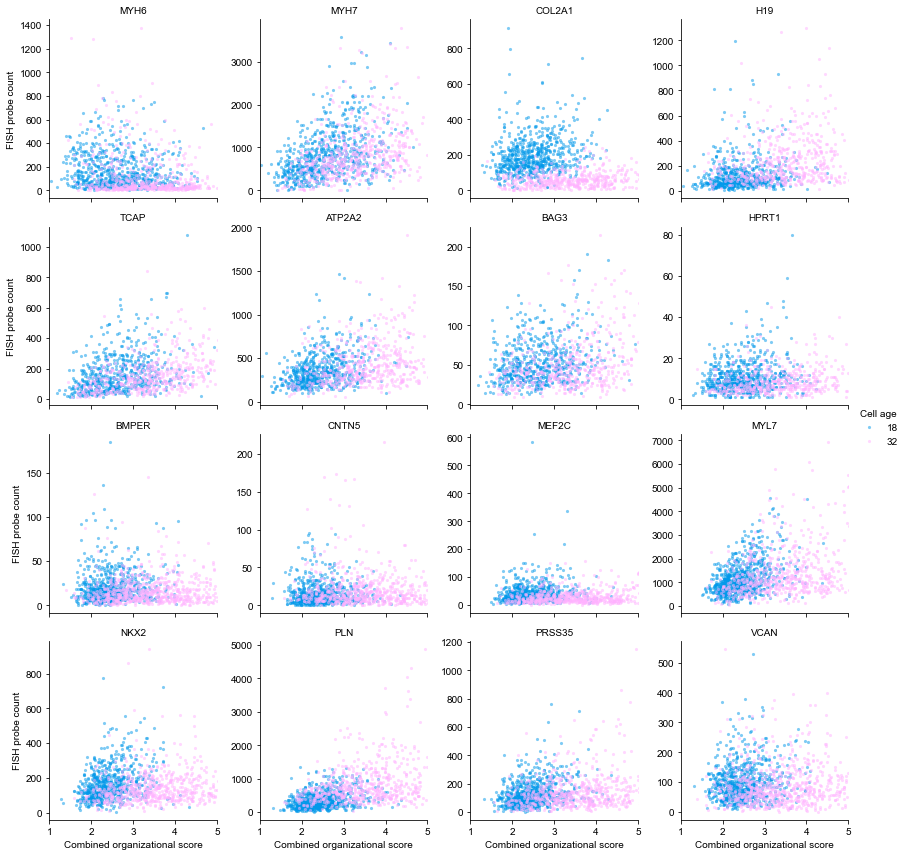

In [42]:
g = sns.FacetGrid(
    data=df_tidy.sample(frac=1, replace=False).reset_index(drop=True),
    col="FISH probe",
    col_order=PROBE_ORDER,
    col_wrap=4,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    sharex=True,
    xlim=(1,5),
    sharey=False,
    height=3.0,
    aspect=1.0,
)

g = g.map(
    plt.scatter,
    "Combined organizational score",
    "FISH probe count",
    s=10,
    alpha=0.5,
    linewidth=0,
).add_legend()

g.set_titles("{col_name}")

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_supp_probe_count_vs_org_score.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_supp_probe_count_vs_org_score.svg', format="svg", bbox_inches = "tight")

## 5b spearman correlation bar charts

In [43]:
df_density_time_stat = pd.DataFrame()

for probe in df_tidy["FISH probe"].unique():
    df_tmp = df_tidy[df_tidy["FISH probe"] == probe][["FISH probe (count/μm^2)", "Cell age"]]
    early_densities = df_tmp[df_tmp["Cell age"] == 18]["FISH probe (count/μm^2)"]
    late_densities = df_tmp[df_tmp["Cell age"] == 32]["FISH probe (count/μm^2)"]
    df_tmp_stat = pg.mwu(early_densities, late_densities).reset_index().rename(columns={"index":"Statistical test"})
    df_tmp_stat["FISH probe"] = probe
    df_density_time_stat = df_density_time_stat.append(df_tmp_stat)
    
df_density_time_stat = df_density_time_stat.reset_index(drop=True)

In [44]:
N_boot=1000

x = "Combined organizational score"
y = "FISH probe (count/μm^2)"
col = "FISH probe"
hue = "Cell age"


df_corr_bar_in = df_tidy[[col, hue, x, y]].copy()
df_corr_bar = pd.DataFrame(columns = [col, hue, f"Spearman R ({x}, {y})", "Spearman p-value"])

N_boot=1000

for i in range(N_boot):
    df_corr_bar_boot = df_corr_bar_in.sample(frac=1, replace=True).reset_index(drop=True)
    for probe in df_tidy[col].unique():

        condition = (df_corr_bar_boot[col] == probe)
        df_tmp = df_corr_bar_boot[condition]
        rho = spearmanr(df_tmp[x], df_tmp[y])
        df_corr_bar = df_corr_bar.append(
            pd.DataFrame({
                "FISH probe": [probe],
                "Cell age": ["all"],
                f"Spearman R ({x}, {y})": [rho[0]],
                "Spearman p-value": [rho[1]],
            })
        )

        for age in df_tidy[hue].unique():
            condition = (df_corr_bar_boot[col] == probe) & (df_corr_bar_boot[hue] == age)
            df_tmp = df_corr_bar_boot[condition]
            rho = spearmanr(df_tmp[x], df_tmp[y])
            df_corr_bar = df_corr_bar.append(
                pd.DataFrame({
                    "FISH probe": [probe],
                    "Cell age": [age],
                    f"Spearman R ({x}, {y})": [rho[0]],
                    "Spearman p-value": [rho[1]],
                })
            )

df_corr_bar = df_corr_bar.reset_index(drop=True)

f = {f"Spearman R ({x}, {y})": ['mean', ci_low, ci_high]}
df_corr_bar_plot = df_corr_bar[[col, hue, f"Spearman R ({x}, {y})"]].groupby([col, hue]).agg(f).reset_index()
df_corr_bar_plot.columns = [" ".join(x).strip() for x in list(zip(*[list(df_corr_bar_plot.columns.get_level_values(i)) for i in (0,1)]))]

df_corr_bar_plot = df_corr_bar_plot.rename(
    columns={
        f"Spearman R ({x}, {y}) mean": f"Spearman R ({x}, {y}) (mean)",
        f"Spearman R ({x}, {y}) ci_low": f"Spearman R ({x}, {y}) (CI low)",
        f"Spearman R ({x}, {y}) ci_high": f"Spearman R ({x}, {y}) (CI high)"
    }
)

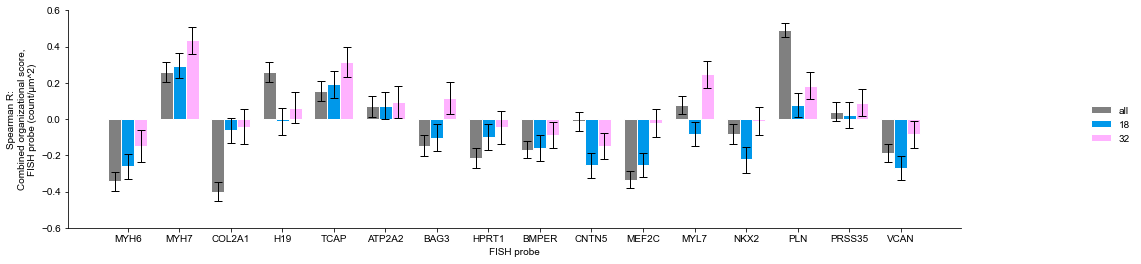

In [45]:
plt.figure(figsize=(16, 4))

df_corr_bar_plot[hue] = df_corr_bar_plot[hue].astype(str)

df_corr_bar_plot_all = df_corr_bar_plot[df_corr_bar_plot[hue] == "all"].set_index(col).loc[PROBE_ORDER, :].reset_index()
df_corr_bar_plot_18 = df_corr_bar_plot[df_corr_bar_plot[hue] == "18"].set_index(col).loc[PROBE_ORDER, :].reset_index()
df_corr_bar_plot_32 = df_corr_bar_plot[df_corr_bar_plot[hue] == "32"].set_index(col).loc[PROBE_ORDER, :].reset_index()

# set width of bar
barWidth = 0.25
 
mean_col = f"Spearman R ({x}, {y}) (mean)"
hi_col = f"Spearman R ({x}, {y}) (CI high)"
low_col = f"Spearman R ({x}, {y}) (CI low)"

# set height of bar
bars_all = df_corr_bar_plot_all[mean_col].values
bars_18 = df_corr_bar_plot_18[mean_col].values
bars_32 = df_corr_bar_plot_32[mean_col].values

# set error bars for each series
err_all = np.array(((df_corr_bar_plot_all[mean_col] - df_corr_bar_plot_all[low_col]).values,
                    (df_corr_bar_plot_all[hi_col] - df_corr_bar_plot_all[mean_col]).values))

err_18 = np.array(((df_corr_bar_plot_18[mean_col] - df_corr_bar_plot_18[low_col]).values,
                   (df_corr_bar_plot_18[hi_col] - df_corr_bar_plot_18[mean_col]).values))

err_32 = np.array(((df_corr_bar_plot_32[mean_col] - df_corr_bar_plot_32[low_col]).values,
                   (df_corr_bar_plot_32[hi_col] - df_corr_bar_plot_32[mean_col]).values))

 
# Set position of bar on X axis
r_all = np.arange(len(bars_all))
r_18 = [x + barWidth for x in r_all]
r_32 = [x + barWidth for x in r_18]
 
# Make the plot
plt.bar(r_all, bars_all, yerr=err_all, color='grey',    width=barWidth, capsize=4, edgecolor='white', label='all', error_kw=dict(elinewidth=1))
plt.bar(r_18, bars_18, yerr=err_18, color=DAY_18_COLOR, width=barWidth, capsize=4, edgecolor='white', label='18',  error_kw=dict(elinewidth=1))
plt.bar(r_32, bars_32, yerr=err_32, color=DAY_32_COLOR, width=barWidth, capsize=4, edgecolor='white', label='32',  error_kw=dict(elinewidth=1))
 
# Add xticks on the middle of the group bars
plt.xlabel(col)
plt.xticks([r + barWidth for r in range(len(bars_all))], df_corr_bar_plot_all[col].unique())
plt.ylim((-0.6, 0.6))
plt.ylabel(f"Spearman R:\n{x},\n{y}")

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.2, 0.6),frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5b_gnxp_vs_struct_corr.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5b_gnxp_vs_struct_corr.svg', format="svg", bbox_inches = "tight")

In [113]:
N_boot=1000

x = 'Fraction cell area organized z-disks'
y = "FISH probe (count/μm^2)"
col = "FISH probe"
hue = "Cell age"


df_corr_bar_in = df_tidy[[col, hue, x, y]].copy()
df_corr_bar = pd.DataFrame(columns = [col, hue, f"Spearman R ({x}, {y})", "Spearman p-value"])

N_boot=1000

for i in range(N_boot):
    df_corr_bar_boot = df_corr_bar_in.sample(frac=1, replace=True).reset_index(drop=True)
    for probe in df_tidy[col].unique():

        condition = (df_corr_bar_boot[col] == probe)
        df_tmp = df_corr_bar_boot[condition]
        rho = spearmanr(df_tmp[x], df_tmp[y])
        df_corr_bar = df_corr_bar.append(
            pd.DataFrame({
                "FISH probe": [probe],
                "Cell age": ["all"],
                f"Spearman R ({x}, {y})": [rho[0]],
                "Spearman p-value": [rho[1]],
            })
        )

        for age in df_tidy[hue].unique():
            condition = (df_corr_bar_boot[col] == probe) & (df_corr_bar_boot[hue] == age)
            df_tmp = df_corr_bar_boot[condition]
            rho = spearmanr(df_tmp[x], df_tmp[y])
            df_corr_bar = df_corr_bar.append(
                pd.DataFrame({
                    "FISH probe": [probe],
                    "Cell age": [age],
                    f"Spearman R ({x}, {y})": [rho[0]],
                    "Spearman p-value": [rho[1]],
                })
            )

df_corr_bar = df_corr_bar.reset_index(drop=True)

f = {f"Spearman R ({x}, {y})": ['mean', ci_low, ci_high]}
df_corr_bar_plot = df_corr_bar[[col, hue, f"Spearman R ({x}, {y})"]].groupby([col, hue]).agg(f).reset_index()
df_corr_bar_plot.columns = [" ".join(x).strip() for x in list(zip(*[list(df_corr_bar_plot.columns.get_level_values(i)) for i in (0,1)]))]

df_corr_bar_plot = df_corr_bar_plot.rename(
    columns={
        f"Spearman R ({x}, {y}) mean": f"Spearman R ({x}, {y}) (mean)",
        f"Spearman R ({x}, {y}) ci_low": f"Spearman R ({x}, {y}) (CI low)",
        f"Spearman R ({x}, {y}) ci_high": f"Spearman R ({x}, {y}) (CI high)"
    }
)

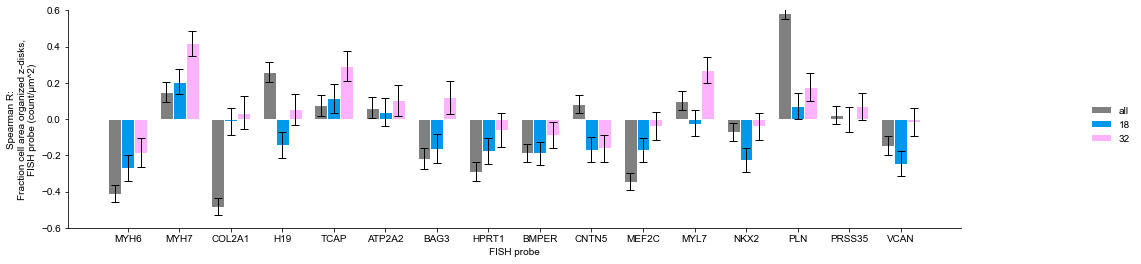

In [114]:
plt.figure(figsize=(16, 4))

df_corr_bar_plot[hue] = df_corr_bar_plot[hue].astype(str)

df_corr_bar_plot_all = df_corr_bar_plot[df_corr_bar_plot[hue] == "all"].set_index(col).loc[PROBE_ORDER, :].reset_index()
df_corr_bar_plot_18 = df_corr_bar_plot[df_corr_bar_plot[hue] == "18"].set_index(col).loc[PROBE_ORDER, :].reset_index()
df_corr_bar_plot_32 = df_corr_bar_plot[df_corr_bar_plot[hue] == "32"].set_index(col).loc[PROBE_ORDER, :].reset_index()

# set width of bar
barWidth = 0.25
 
mean_col = f"Spearman R ({x}, {y}) (mean)"
hi_col = f"Spearman R ({x}, {y}) (CI high)"
low_col = f"Spearman R ({x}, {y}) (CI low)"

# set height of bar
bars_all = df_corr_bar_plot_all[mean_col].values
bars_18 = df_corr_bar_plot_18[mean_col].values
bars_32 = df_corr_bar_plot_32[mean_col].values

# set error bars for each series
err_all = np.array(((df_corr_bar_plot_all[mean_col] - df_corr_bar_plot_all[low_col]).values,
                    (df_corr_bar_plot_all[hi_col] - df_corr_bar_plot_all[mean_col]).values))

err_18 = np.array(((df_corr_bar_plot_18[mean_col] - df_corr_bar_plot_18[low_col]).values,
                   (df_corr_bar_plot_18[hi_col] - df_corr_bar_plot_18[mean_col]).values))

err_32 = np.array(((df_corr_bar_plot_32[mean_col] - df_corr_bar_plot_32[low_col]).values,
                   (df_corr_bar_plot_32[hi_col] - df_corr_bar_plot_32[mean_col]).values))

 
# Set position of bar on X axis
r_all = np.arange(len(bars_all))
r_18 = [x + barWidth for x in r_all]
r_32 = [x + barWidth for x in r_18]
 
# Make the plot
plt.bar(r_all, bars_all, yerr=err_all, color='grey',    width=barWidth, capsize=4, edgecolor='white', label='all', error_kw=dict(elinewidth=1))
plt.bar(r_18, bars_18, yerr=err_18, color=DAY_18_COLOR, width=barWidth, capsize=4, edgecolor='white', label='18',  error_kw=dict(elinewidth=1))
plt.bar(r_32, bars_32, yerr=err_32, color=DAY_32_COLOR, width=barWidth, capsize=4, edgecolor='white', label='32',  error_kw=dict(elinewidth=1))
 
# Add xticks on the middle of the group bars
plt.xlabel(col)
plt.xticks([r + barWidth for r in range(len(bars_all))], df_corr_bar_plot_all[col].unique())
plt.ylim((-0.6, 0.6))
plt.ylabel(f"Spearman R:\n{x},\n{y}")

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.2, 0.6),frameon=False)
sns.despine()

# # save png and svg
# if SAVE:
#     plt.savefig(save_dir_pngs/'fig_5b_gnxp_vs_struct_corr.png', dpi=100, bbox_inches = "tight")
#     plt.savefig(save_dir_svgs/'fig_5b_gnxp_vs_struct_corr.svg', format="svg", bbox_inches = "tight")

In [46]:
N_boot=1000

x = "Combined organizational score"
y = "FISH probe count"
col = "FISH probe"
hue = "Cell age"

df_corr_bar_in = df_tidy[[col, hue, x, y]].copy()
df_corr_bar = pd.DataFrame(columns = [col, hue, f"Spearman R ({x}, {y})", "Spearman R p-value"])

for i in range(N_boot):
    df_corr_bar_boot = df_corr_bar_in.sample(frac=1, replace=True).reset_index(drop=True)
    for probe in df_tidy[col].unique():

        condition = (df_corr_bar_boot[col] == probe)
        df_tmp = df_corr_bar_boot[condition]
        rho = spearmanr(df_tmp[x], df_tmp[y])
        df_corr_bar = df_corr_bar.append(
            pd.DataFrame({
                f"{col}": [probe],
                f"{hue}": ["all"],
                f"Spearman R ({x}, {y})": [rho[0]],
                "Spearman p-value": [rho[1]],
            })
        )

        for age in df_tidy[hue].unique():
            condition = (df_corr_bar_boot[col] == probe) & (df_corr_bar_boot[hue] == age)
            df_tmp = df_corr_bar_boot[condition]
            rho = spearmanr(df_tmp[x], df_tmp[y])
            df_corr_bar = df_corr_bar.append(
                pd.DataFrame({
                    f"{col}": [probe],
                    f"{hue}": [age],
                    f"Spearman R ({x}, {y})": [rho[0]],
                    "Spearman p-value": [rho[1]],
                })
            )

df_corr_bar = df_corr_bar.reset_index(drop=True)

f = {f"Spearman R ({x}, {y})": ['mean', ci_low, ci_high]}
df_corr_bar_plot = df_corr_bar[[f"{col}", f"{hue}", f"Spearman R ({x}, {y})"]].groupby([col, hue]).agg(f).reset_index()
df_corr_bar_plot.columns = [" ".join(x).strip() for x in list(zip(*[list(df_corr_bar_plot.columns.get_level_values(i)) for i in (0,1)]))]

df_corr_bar_plot = df_corr_bar_plot.rename(
    columns={
        f"Spearman R ({x}, {y}) mean": f"Spearman R ({x}, {y}) (mean)",
        f"Spearman R ({x}, {y}) ci_low": f"Spearman R ({x}, {y}) (CI low)",
        f"Spearman R ({x}, {y}) ci_high": f"Spearman R ({x}, {y}) (CI high)"
    }
)

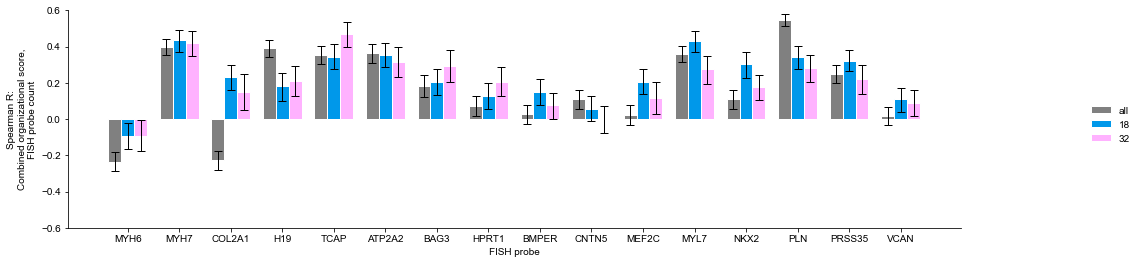

In [47]:
plt.figure(figsize=(16, 4))

df_corr_bar_plot[hue] = df_corr_bar_plot[hue].astype(str)

df_corr_bar_plot_all = df_corr_bar_plot[df_corr_bar_plot[hue] == "all"].set_index("FISH probe").loc[PROBE_ORDER, :].reset_index()
df_corr_bar_plot_18 = df_corr_bar_plot[df_corr_bar_plot[hue] == "18"].set_index("FISH probe").loc[PROBE_ORDER, :].reset_index()
df_corr_bar_plot_32 = df_corr_bar_plot[df_corr_bar_plot[hue] == "32"].set_index("FISH probe").loc[PROBE_ORDER, :].reset_index()

# set width of bar
barWidth = 0.25

mean_col = f"Spearman R ({x}, {y}) (mean)"
hi_col = f"Spearman R ({x}, {y}) (CI high)"
low_col = f"Spearman R ({x}, {y}) (CI low)"

# set height of bar
bars_all = df_corr_bar_plot_all[mean_col].values
bars_18 = df_corr_bar_plot_18[mean_col].values
bars_32 = df_corr_bar_plot_32[mean_col].values

# set error bars for each series
err_all = np.array(((df_corr_bar_plot_all[mean_col] - df_corr_bar_plot_all[low_col]).values,
                    (df_corr_bar_plot_all[hi_col] - df_corr_bar_plot_all[mean_col]).values))

err_18 = np.array(((df_corr_bar_plot_18[mean_col] - df_corr_bar_plot_18[low_col]).values,
                   (df_corr_bar_plot_18[hi_col] - df_corr_bar_plot_18[mean_col]).values))

err_32 = np.array(((df_corr_bar_plot_32[mean_col] - df_corr_bar_plot_32[low_col]).values,
                   (df_corr_bar_plot_32[hi_col] - df_corr_bar_plot_32[mean_col]).values))

# Set position of bar on X axis
r_all = np.arange(len(bars_all))
r_18 = [x + barWidth for x in r_all]
r_32 = [x + barWidth for x in r_18]

# Make the plot
plt.bar(r_all, bars_all, yerr=err_all, color='grey',       width=barWidth, capsize=4, edgecolor='white', label='all', error_kw=dict(elinewidth=1))
plt.bar(r_18, bars_18, yerr=err_18, color=DAY_18_COLOR, width=barWidth, capsize=4, edgecolor='white', label='18', error_kw=dict(elinewidth=1))
plt.bar(r_32, bars_32, yerr=err_32, color=DAY_32_COLOR, width=barWidth, capsize=4, edgecolor='white', label='32', error_kw=dict(elinewidth=1))

# Add xticks on the middle of the group bars
plt.xlabel(col)
plt.xticks([r + barWidth for r in range(len(bars_all))], df_corr_bar_plot_all["FISH probe"].unique())
plt.ylim((-0.6, 0.6))
plt.ylabel(f"Spearman R:\n{x},\n{y}")

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.2, 0.6),frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_supp_probe_count_vs_struct_corr.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_supp_probe_count_vs_struct_corr.svg', format="svg", bbox_inches = "tight")

## 5c myh7-myh6

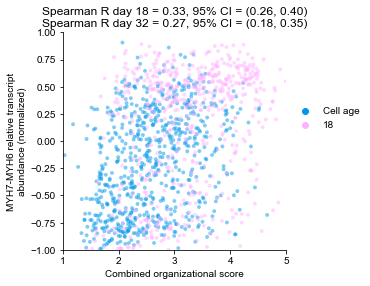

In [48]:
x = "Combined organizational score"
y = "MYH7-MYH6 relative transcript abundance (normalized)"
stratify = "Cell age"

plt.figure(figsize=(4, 4))

plot_myh67_vs_org_score = sns.scatterplot(
    data=df.dropna(subset=[x,y]),
    x=x,
    y=y,
    hue=stratify,
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    linewidth=0,
    alpha = 0.5,
    s=15
)
plot_myh67_vs_org_score.set(
    xlim=(1, 5),
    ylim=(-1, 1),
    ylabel=y.replace("transcript abundance", "transcript\nabundance")
);

handles, _ = plot_myh67_vs_org_score.get_legend_handles_labels()
plot_myh67_vs_org_score.legend(handles, ["Cell age", "18", "32"], bbox_to_anchor=(1.0, 0.7), frameon=False)


df_boot_spr = boot_spearmanr(df, x=x, y=y, stratify=stratify, N=1000)

mean_col = f"Spearman R ({x}, {y}) (mean)"
hi_col = f"Spearman R ({x}, {y}) (CI high)"
low_col = f"Spearman R ({x}, {y}) (CI low)"

title = "\n".join([
    f"Spearman R day {day} = {row[mean_col]:.2f}, 95% CI = ({row[low_col]:.2f}, {row[hi_col]:.2f})"
    for day, row in df_boot_spr.set_index(stratify).iterrows()
])

plt.title(title)

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5c_linear_model_vs_myh_diff_scatter.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5c_linear_model_vs_myh_diff_scatter.svg', format="svg", bbox_inches = "tight")

In [49]:
df_dummy = pd.concat([df,pd.DataFrame(np.zeros(len(df)), columns=["MYH67 vs org score all cells"])], axis=1)
boot_spearmanr(df_dummy, x=x, y=y, stratify="MYH67 vs org score all cells", N=1000)

MYH67 vs org score all cells  \
0                          0.0   

   Spearman R (Combined organizational score, MYH7-MYH6 relative transcript abundance (normalized)) (mean)  \
0                                           0.399907                                                         

   Spearman R (Combined organizational score, MYH7-MYH6 relative transcript abundance (normalized)) (CI low)  \
0                                           0.348447                                                           

   Spearman R (Combined organizational score, MYH7-MYH6 relative transcript abundance (normalized)) (CI high)  
0                                           0.447429

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

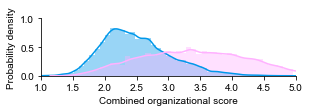

In [50]:
bins = np.linspace(1,5,51)
bins -= (bins[1]-bins[0])/2

g = sns.FacetGrid(
    data=df,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=1.5,
    aspect=2.75,
)
g = g.map(
    sns.distplot,
    "Combined organizational score",
    bins=bins,
    kde_kws=dict(bw=0.1)
)
g.set(ylabel='Probability density')
g.set(xlim=(1, 5));
g.set(ylim=(0, 1));

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5c_linear_model_vs_myh_diff_top_hist.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5c_linear_model_vs_myh_diff_top_hist.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

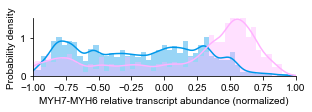

In [51]:
bins = np.linspace(-1,1,51)
bins -= (bins[1]-bins[0])/2

g = sns.FacetGrid(
    data=df,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=1.5,
    aspect=2.75,
)
g = g.map(
    sns.distplot,
    "MYH7-MYH6 relative transcript abundance (normalized)",
    bins=bins,
    kde_kws=dict(bw=0.1)
)
g.set(ylabel='Probability density')
g.set(xlim=(-1,1));
g.set(ylim=(0, 1.5));

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5c_linear_model_vs_myh_diff_right_hist.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5c_linear_model_vs_myh_diff_right_hist.svg', format="svg", bbox_inches = "tight")

## 5c supplement -- myh67 diff from feats directly

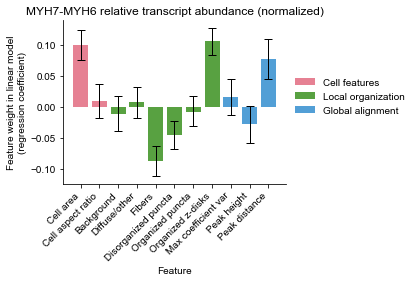

In [52]:
df_boot_reg = boot_regression(
    df.dropna(subset=["MYH7-MYH6 relative transcript abundance (normalized)"]),
    N=1000,
    X_cols=BAR_PLOT_COLUMNS,
    y_col="MYH7-MYH6 relative transcript abundance (normalized)",
    weight_col=None,
)

reg_plot_ci_df = make_reg_plot_ci_df(df_boot_reg)

fig_bar, ax_bar = make_regression_bar_plot(reg_plot_ci_df, title="MYH7-MYH6 relative transcript abundance (normalized)")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5f_predict_MYH67_diff_coefs.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5f_predict_MYH67_diff_coefs.svg', format="svg", bbox_inches = "tight")

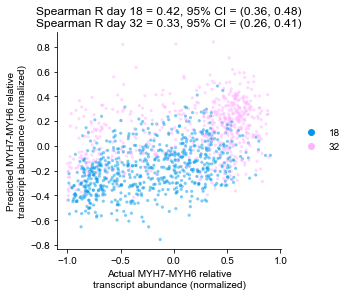

In [53]:
x = 'MYH7-MYH6 relative transcript abundance (normalized)'
y = 'MYH7-MYH6 relative transcript abundance (normalized) predicted'
stratify = 'Cell age'

df_pred_true  = get_pred_true(
    df.dropna(subset=[x]).reset_index(drop=True),
    y_col=x,
    weight_col=None,
    meta_cols=[stratify]
)

df_boot_spr = boot_spearmanr(df_pred_true, x=x, y=y, stratify=stratify, N=1000)

mean_col = f"Spearman R ({x}, {y}) (mean)"
hi_col = f"Spearman R ({x}, {y}) (CI high)"
low_col = f"Spearman R ({x}, {y}) (CI low)"

title = "\n".join([
    f"Spearman R day {day} = {row[mean_col]:.2f}, 95% CI = ({row[low_col]:.2f}, {row[hi_col]:.2f})"
    for day, row in df_boot_spr.set_index(stratify).iterrows()
])

fig_scatter, ax_scatter = make_regression_scatter_plot(df_pred_true, target=x, title=title);
ax_scatter.set(
    xlabel=x.replace("MYH7-MYH6", "Actual MYH7-MYH6").replace("relative transcript", "relative\ntranscript"),
    ylabel=x.replace("MYH7-MYH6", "Predicted MYH7-MYH6").replace("relative transcript", "relative\ntranscript")
)
plt.legend(bbox_to_anchor=(1.05, 0.6),frameon=False)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5e_predict_MYH67_diff.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5e_predict_MYH67_diff.svg', format="svg", bbox_inches = "tight")

In [54]:
df_dummy = pd.concat([df_pred_true,pd.DataFrame(np.zeros(len(df_pred_true)),
                                                columns=["MYH67 pred vs true all cells"])], axis=1)
boot_spearmanr(df_dummy, x=x, y=y, stratify="MYH67 pred vs true all cells", N=1000)

MYH67 pred vs true all cells  \
0                          0.0   

   Spearman R (MYH7-MYH6 relative transcript abundance (normalized), MYH7-MYH6 relative transcript abundance (normalized) predicted) (mean)  \
0                                           0.498151                                                                                          

   Spearman R (MYH7-MYH6 relative transcript abundance (normalized), MYH7-MYH6 relative transcript abundance (normalized) predicted) (CI low)  \
0                                           0.455444                                                                                            

   Spearman R (MYH7-MYH6 relative transcript abundance (normalized), MYH7-MYH6 relative transcript abundance (normalized) predicted) (CI high)  
0                                            0.54012

## 5supp count and density distributions

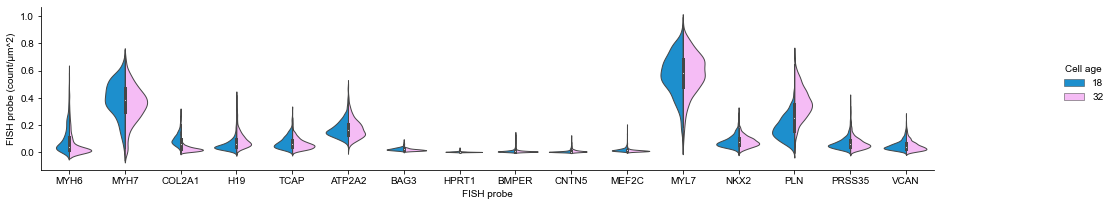

In [55]:
dims = (16,3)
fig, ax = plt.subplots(figsize=dims)

ax = sns.violinplot(
    data=df_tidy.sample(frac=1, replace=False).reset_index(drop=True),
    x="FISH probe",
    order=PROBE_ORDER,
    y="FISH probe (count/μm^2)",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    split=True,
    linewidth=1
)

plt.legend(bbox_to_anchor=(1.2, 0.7), frameon=False, title="Cell age");
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5supp_probe_density_violin_plots.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5supp_probe_density_violin_plots.svg', format="svg", bbox_inches = "tight")

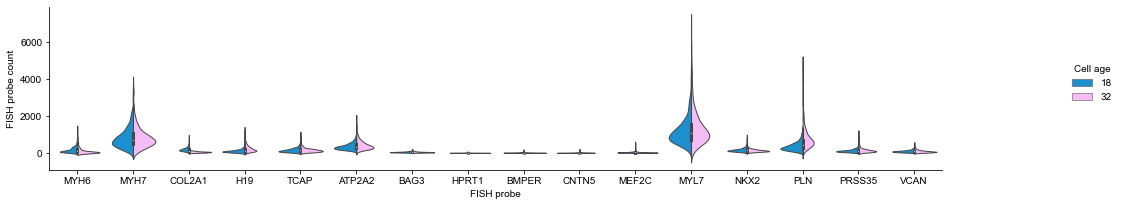

In [56]:
dims = (16,3)
fig, ax = plt.subplots(figsize=dims)

ax = sns.violinplot(
    data=df_tidy.sample(frac=1, replace=False).reset_index(drop=True),
    x="FISH probe",
    order=PROBE_ORDER,
    y="FISH probe count",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    split=True,
    linewidth=1
)

plt.legend(bbox_to_anchor=(1.2, 0.7), frameon=False, title="Cell age");
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_5supp_probe_count_violin_plots.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_5supp_probe_count_violin_plots.svg', format="svg", bbox_inches = "tight")

## 6c & d -- hand scored sarcomeric vs not

In [57]:
df_becky_loc_summary = pd.concat(
    [
        pd.concat(
            [
                df.dropna(
                    subset=[f"{x} localization"]
                )[f"{x} localization"].groupby(
                    df.dropna(subset=[f"{x} localization"])["Cell age"]
                ).value_counts(
                    normalize=True
                ).rename("Fraction").reset_index().rename(columns={f"{x} localization":"Localization"}),
                pd.DataFrame(
                    {
                        "FISH probe": [x]*len(set(df["Cell age"]))*len(set(df["MYH7 localization"].dropna()) | set(df["MYH6 localization"].dropna()))
                    }
                )
            ], axis="columns"
        )
        for x in ["MYH6", "MYH7"]
]
).reset_index(
    drop=True
)
df_becky_loc_summary["Cell age"] = df_becky_loc_summary["Cell age"].astype(str)

In [58]:
df.dropna(subset=['MYH6 localization','MYH7 localization']).groupby(
    ["Cell age"]
).size().reset_index().rename(columns={0:'Count'})

Cell age  Count
0        18    709
1        32    559

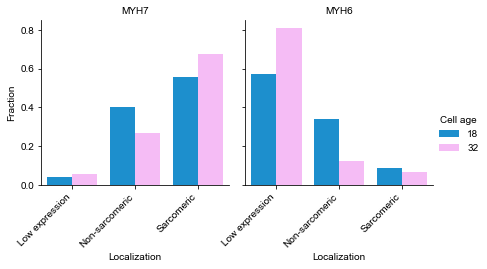

In [59]:
g = sns.catplot(
    data=df_becky_loc_summary,
    kind="bar",
    col="FISH probe",
    col_order=["MYH7", "MYH6"],
    x="Localization",
    order=["Low expression", "Non-sarcomeric", "Sarcomeric"],
    y="Fraction",
    hue="Cell age",
    hue_order=["18", "32"],
    palette=DAY_COLOR_PALETTE,
    height=3,
    aspect=1
);
g.set_titles("{col_name}") 
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    
# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6cd_predict_MYH67_diff.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6cd_predict_MYH67_diff.svg', format="svg", bbox_inches = "tight")

## 6e

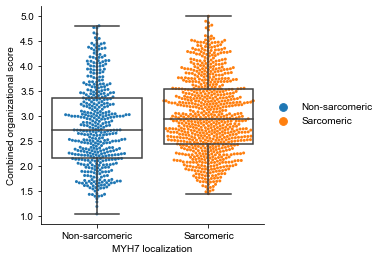

In [60]:
dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)

ax = sns.swarmplot(
    data=df[df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])],
    x="MYH7 localization",
    y='Combined organizational score',
    hue="MYH7 localization",
    hue_order=["Non-sarcomeric", "Sarcomeric"],
    zorder=0,
    s=3
)

sns.boxplot(
    data=df[df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])],
    x="MYH7 localization",
    order=["Non-sarcomeric", "Sarcomeric"],
    y="Combined organizational score",
    showcaps=True,
    boxprops={'facecolor':'None'},
    showfliers=False,
    ax=ax
)

plt.legend(bbox_to_anchor=(1.0, 0.6), frameon=False);

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6e_linear_model_org_by_becky_swarmbox.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6e_linear_model_org_by_becky_swarmbox.svg', format="svg", bbox_inches = "tight")

In [61]:
sarc = df[df["MYH7 localization"] == "Sarcomeric"]["Combined organizational score"]
non_sarc = df[df["MYH7 localization"] == 'Non-sarcomeric']["Combined organizational score"]
pg.mwu(sarc, non_sarc)

U-val       tail     p-val       RBC      CLES
MWU  194928.0  two-sided  0.000004 -0.160576  0.580288

In [62]:
df[df["MYH7 localization"].isin(
    ["Non-sarcomeric", "Sarcomeric"]
)].groupby(
    ["Cell age"]
).size().reset_index().rename(columns={0:'Count'})

Cell age  Count
0        18    680
1        32    528

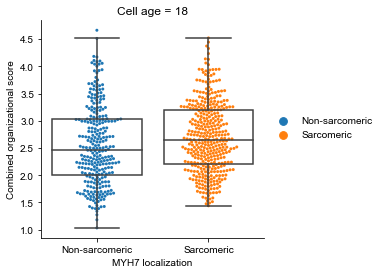

In [63]:
cell_age = 18

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)

ax = sns.swarmplot(
    data=df[(df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])) & (df["Cell age"]==cell_age)],
    x="MYH7 localization",
    order=["Non-sarcomeric", "Sarcomeric"],
    y="Combined organizational score",
    hue="MYH7 localization",
    hue_order=["Non-sarcomeric", "Sarcomeric"],
    zorder=0,
    s=3
)

sns.boxplot(
    data=df[(df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])) & (df["Cell age"]==cell_age)],
    x="MYH7 localization",
    order=["Non-sarcomeric", "Sarcomeric"],
    y="Combined organizational score",
    showcaps=True,
    boxprops={'facecolor':'None'},
    showfliers=False,
    ax=ax
)

ax.set(title=f"Cell age = {cell_age}")
plt.legend(bbox_to_anchor=(1.0, 0.6), frameon=False);

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f'fig_6e_linear_model_org_by_becky_swarmbox_and_day_{cell_age}.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'fig_6e_linear_model_org_by_becky_swarmbox_and_day_{cell_age}.svg', format="svg", bbox_inches = "tight")

In [64]:
cell_age = 18

sarc = df[(df["MYH7 localization"] == "Sarcomeric") & (df["Cell age"]==cell_age)]["Combined organizational score"]
non_sarc = df[(df["MYH7 localization"] == "Non-sarcomeric") & (df["Cell age"]==cell_age)]["Combined organizational score"]
pg.mwu(sarc, non_sarc)

U-val       tail     p-val       RBC      CLES
MWU  63901.0  two-sided  0.002402 -0.136381  0.568191

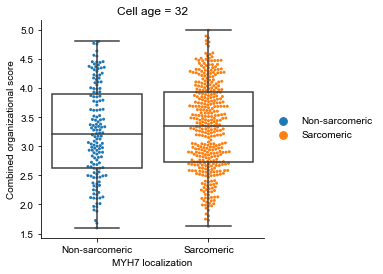

In [65]:
cell_age = 32

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)

ax = sns.swarmplot(
    data=df[(df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])) & (df["Cell age"]==cell_age)],
    x="MYH7 localization",
    order=["Non-sarcomeric", "Sarcomeric"],
    y="Combined organizational score",
    hue="MYH7 localization",
    hue_order=["Non-sarcomeric", "Sarcomeric"],
    zorder=0,
    s=3
)

sns.boxplot(
    data=df[(df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])) & (df["Cell age"]==cell_age)],
    x="MYH7 localization",
    order=["Non-sarcomeric", "Sarcomeric"],
    y="Combined organizational score",
    showcaps=True,
    boxprops={'facecolor':'None'},
    showfliers=False,
    ax=ax
)

ax.set(title=f"Cell age = {cell_age}")
plt.legend(bbox_to_anchor=(1.0, 0.6), frameon=False);

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f'fig_6e_linear_model_org_by_becky_swarmbox_and_day_{cell_age}.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'fig_6e_linear_model_org_by_becky_swarmbox_and_day_{cell_age}.svg', format="svg", bbox_inches = "tight")

In [66]:
cell_age = 32

sarc = df[(df["MYH7 localization"] == "Sarcomeric") & (df["Cell age"]==cell_age)]["Combined organizational score"]
non_sarc = df[(df["MYH7 localization"] == "Non-sarcomeric") & (df["Cell age"]==cell_age)]["Combined organizational score"]
pg.mwu(sarc, non_sarc)

U-val       tail     p-val       RBC      CLES
MWU  30231.0  two-sided  0.234264 -0.066349  0.533175

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


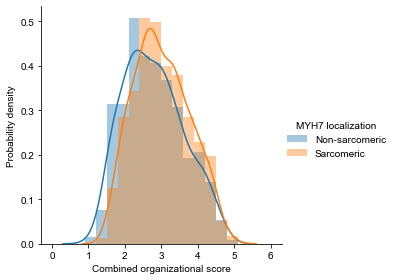

In [67]:
bins = np.linspace(0,6,21)

g = sns.FacetGrid(
    data=df[df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])],
    hue="MYH7 localization",
    height=4,
    aspect=1,
)
g = g.map(
    sns.distplot,
    "Combined organizational score",
    bins=bins
).add_legend()

g.set(
    ylabel='Probability density'
)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6e_linear_model_org_by_becky.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6e_linear_model_org_by_becky.svg', format="svg", bbox_inches = "tight")

## 6 supp c

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

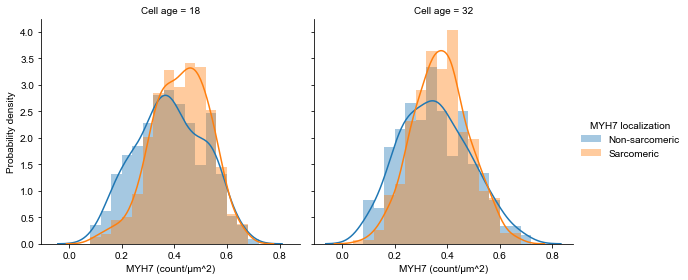

In [68]:
bins = np.linspace(0,0.8,21)

g = sns.FacetGrid(
    data=df[df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])],
    hue="MYH7 localization",
    height=4,
    aspect=1,
    col="Cell age"
)
g = g.map(
    sns.distplot,
    'MYH7 (count/μm^2)',
    bins=bins
).add_legend()

g.set(
    ylabel='Probability density'
)

g.set_titles("Cell age = {col_name}")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6supp_c_myh7_density_hist_by_sarc_and_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6supp_c_myh7_density_hist_by_sarc_and_day.svg', format="svg", bbox_inches = "tight")

## 6 supp d

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

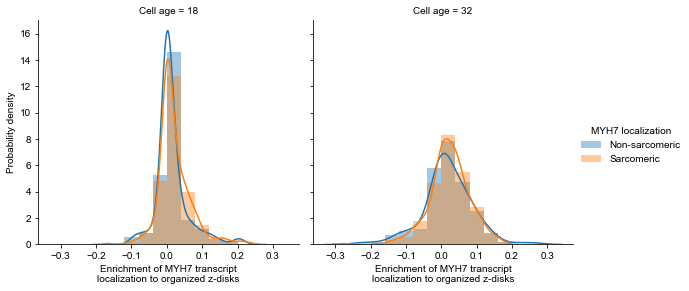

In [69]:
x = 'Enrichment of MYH7 transcript localization to organized z-disks'

bins = np.linspace(-0.2, 0.2, 11)

g = sns.FacetGrid(
    data=df[df["MYH7 localization"].isin(["Non-sarcomeric", "Sarcomeric"])],
    hue="MYH7 localization",
    height=4,
    aspect=1,
    col="Cell age"
)
g = g.map(
    sns.distplot,
    x,
    bins=bins
).add_legend()

g.set(
    xlabel=x.replace("transcript ", "transcript\n"),
    ylabel='Probability density'
)

g.set_titles("Cell age = {col_name}")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6supp_d_myh7_loc_enrichment_hist_by_sarc_and_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6supp_d_myh7_loc_enrichment_hist_by_sarc_and_day.svg', format="svg", bbox_inches = "tight")

## 6f

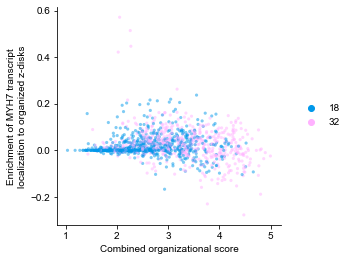

In [70]:
y = "Enrichment of MYH7 transcript localization to organized z-disks"

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
ax = sns.scatterplot(
    data=df.sample(frac=1, replace=False).reset_index(drop=True),
    x="Combined organizational score",
    y=y,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    alpha=0.5,
    linewidth=0,
    s=10
)
sns.despine();

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Cell age", "18", "32"])
ax.set(ylabel=y.replace("transcript localization", "transcript\nlocalization"))

plt.legend(bbox_to_anchor=(1.05, 0.6),frameon=False)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6f_MYH7_loc_regular_stripes_vs_linear_model_org_by_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6f_MYH7_loc_regular_stripes_vs_linear_model_org_by_day.svg', format="svg", bbox_inches = "tight")

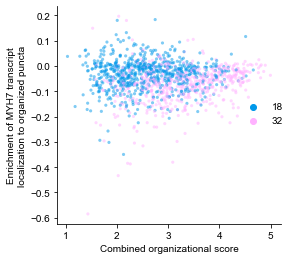

In [71]:
y = "Enrichment of MYH7 transcript localization to organized puncta"

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
ax = sns.scatterplot(
    data=df.sample(frac=1, replace=False).reset_index(drop=True),
    x="Combined organizational score",
    y=y,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    alpha=0.5,
    linewidth=0,
    s=10
)
sns.despine();

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Cell age", "18", "32"])
ax.set(ylabel=y.replace("transcript localization", "transcript\nlocalization"))

plt.legend(bbox_to_anchor=(1.05, 0.6),frameon=False)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6f_MYH7_loc_regular_dots_vs_linear_model_org_by_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6f_MYH7_loc_regular_dots_vs_linear_model_org_by_day.svg', format="svg", bbox_inches = "tight")

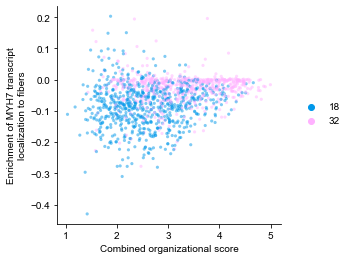

In [72]:
y = "Enrichment of MYH7 transcript localization to fibers"

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
ax = sns.scatterplot(
    data=df.sample(frac=1, replace=False).reset_index(drop=True),
    x="Combined organizational score",
    y=y,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    alpha=0.5,
    linewidth=0,
    s=10
)
sns.despine();

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Cell age", "18", "32"])
ax.set(ylabel=y.replace("transcript localization", "transcript\nlocalization"))

plt.legend(bbox_to_anchor=(1.05, 0.6),frameon=False)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6f_MYH7_loc_threads_vs_linear_model_org_by_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6f_MYH7_loc_threads_vs_linear_model_org_by_day.svg', format="svg", bbox_inches = "tight")

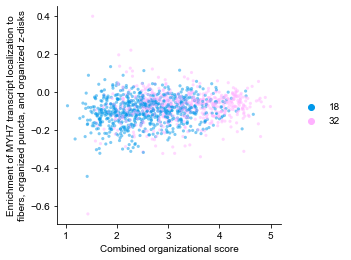

In [73]:
y = "Enrichment of MYH7 transcript localization to fibers, organized puncta, and organized z-disks"

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
ax = sns.scatterplot(
    data=df.sample(frac=1, replace=False).reset_index(drop=True),
    x="Combined organizational score",
    y=y,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    alpha=0.5,
    linewidth=0,
    s=10
)
sns.despine();

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Cell age", "18", "32"])
ax.set(ylabel=y.replace("to ", "to\n"))

plt.legend(bbox_to_anchor=(1.05, 0.6),frameon=False)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_6f_MYH7_loc_sum_vs_linear_model_org_by_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_6f_MYH7_loc_sum_vs_linear_model_org_by_day.svg', format="svg", bbox_inches = "tight")

# Speculative

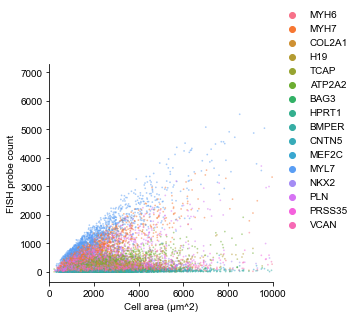

In [74]:
dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
g = sns.scatterplot(
    data=df_tidy.sample(frac=1, replace=False).reset_index(drop=True),
    x='Cell area (μm^2)',
    y="FISH probe count",
    hue="FISH probe",
    s=3,
    hue_order=PROBE_ORDER,
    alpha=0.5,
    linewidth=0,
)
g.set(xlim=(0,10_000));

plt.legend(bbox_to_anchor=(1.0, 0.2), frameon=False)
sns.despine();

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_supp_cell_area_vs_probe_count.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_supp_cell_area_vs_probe_count.svg', format="svg", bbox_inches = "tight")

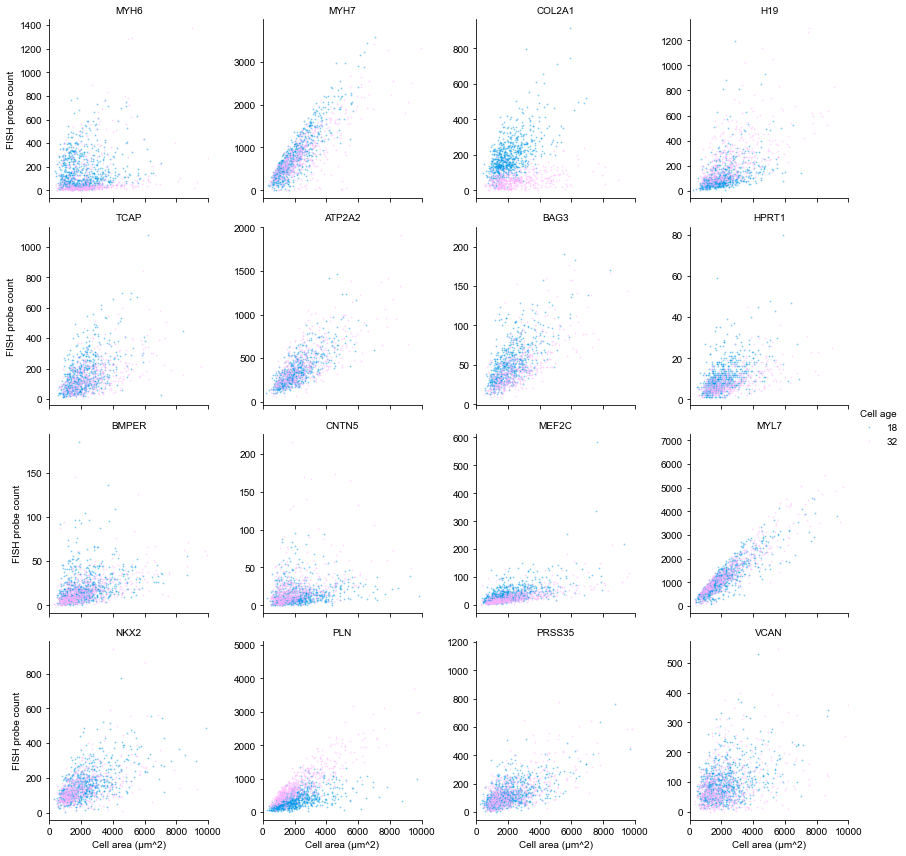

In [75]:
g = sns.FacetGrid(
    data=df_tidy.sample(frac=1, replace=False).reset_index(drop=True),
    col="FISH probe",
    col_order=PROBE_ORDER,
    col_wrap=4,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    sharex=True,
    xlim=(0,10_000),
    sharey=False,
    height=3.0,
    aspect=1.0,
)

g = g.map(
    plt.scatter,
    'Cell area (μm^2)',
    "FISH probe count",
    s=3,
    alpha=0.5,
    linewidth=0,
).add_legend()

g.set_titles("{col_name}")

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_supp_cell_area_vs_probe_count_faceted.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_supp_cell_area_vs_probe_count_faceted.svg', format="svg", bbox_inches = "tight")

In [76]:
boot_spearmanr(
    df_tidy,
    x='Cell area (μm^2)',
    y="FISH probe count",
    stratify="FISH probe",
    N=1000
)

FISH probe  Spearman R (Cell area (μm^2), FISH probe count) (mean)  \
0      ATP2A2                                           0.725520        
1        BAG3                                           0.625666        
2       BMPER                                           0.464360        
3       CNTN5                                           0.314909        
4      COL2A1                                           0.180555        
5         H19                                           0.563721        
6       HPRT1                                           0.507140        
7       MEF2C                                           0.612296        
8        MYH6                                           0.086138        
9        MYH7                                           0.783293        
10       MYL7                                           0.883552        
11       NKX2                                           0.548435        
12        PLN                                           0.624140        
13     PRSS35                                           0.524180        
14       TCAP                                           0.489610        
15       VCAN                                           0.309475        

    Spearman R (Cell area (μm^2), FISH probe count) (CI low)  \
0                                            0.694814          
1                                            0.587377          
2                                            0.422546          
3                                            0.264382          
4                                            0.121580          
5                                            0.520477          
6                                            0.461009          
7                                            0.577702          
8                                            0.037298          
9                                            0.753171          
10                                           0.868147          
11                                           0.508080          
12                                           0.590111          
13                                           0.483275          
14                                           0.439996          
15                                           0.262891          

    Spearman R (Cell area (μm^2), FISH probe count) (CI high)  
0                                            0.755584          
1                                            0.661377          
2                                            0.504216          
3                                            0.362141          
4                                            0.240884          
5                                            0.604075          
6                                            0.549980          
7                                            0.646655          
8                                            0.136618          
9                                            0.810315          
10                                           0.898311          
11                                           0.584160          
12                                           0.655982          
13                                           0.562971          
14                                           0.534350          
15                                           0.354858

In [77]:
age = 18

df_area_corr = boot_spearmanr(
    df_tidy[df_tidy["Cell age"] == age],
    x='Cell area (μm^2)',
    y="FISH probe count",
    stratify="FISH probe",
    N=1000
)

df_area_corr = pd.concat([pd.DataFrame({"Cell age":[age]*len(df_area_corr)}), df_area_corr], axis=1)
df_area_corr

Cell age FISH probe  \
0         18     ATP2A2   
1         18       BAG3   
2         18      BMPER   
3         18      CNTN5   
4         18     COL2A1   
5         18        H19   
6         18      HPRT1   
7         18      MEF2C   
8         18       MYH6   
9         18       MYH7   
10        18       MYL7   
11        18       NKX2   
12        18        PLN   
13        18     PRSS35   
14        18       TCAP   
15        18       VCAN   

    Spearman R (Cell area (μm^2), FISH probe count) (mean)  \
0                                            0.738964        
1                                            0.623960        
2                                            0.369590        
3                                            0.275122        
4                                            0.529747        
5                                            0.526627        
6                                            0.517701        
7                                            0.582879        
8                                            0.079689        
9                                            0.842664        
10                                           0.860357        
11                                           0.549511        
12                                           0.646955        
13                                           0.505871        
14                                           0.497044        
15                                           0.324805        

    Spearman R (Cell area (μm^2), FISH probe count) (CI low)  \
0                                            0.700592          
1                                            0.570815          
2                                            0.311136          
3                                            0.202360          
4                                            0.469516          
5                                            0.465888          
6                                            0.460573          
7                                            0.537405          
8                                            0.009868          
9                                            0.816407          
10                                           0.834914          
11                                           0.493783          
12                                           0.603698          
13                                           0.451669          
14                                           0.433108          
15                                           0.262810          

    Spearman R (Cell area (μm^2), FISH probe count) (CI high)  
0                                            0.776440          
1                                            0.669772          
2                                            0.432928          
3                                            0.342048          
4                                            0.586420          
5                                            0.583817          
6                                            0.575679          
7                                            0.629420          
8                                            0.150455          
9                                            0.867404          
10                                           0.882734          
11                                           0.598137          
12                                           0.688032          
13                                           0.557430          
14                                           0.553340          
15                                           0.388688

In [78]:
age = 32

df_area_corr = boot_spearmanr(
    df_tidy[df_tidy["Cell age"] == age],
    x='Cell area (μm^2)',
    y="FISH probe count",
    stratify="FISH probe",
    N=1000
)

df_area_corr = pd.concat([pd.DataFrame({"Cell age":[age]*len(df_area_corr)}), df_area_corr], axis=1)
df_area_corr

Cell age FISH probe  \
0         32     ATP2A2   
1         32       BAG3   
2         32      BMPER   
3         32      CNTN5   
4         32     COL2A1   
5         32        H19   
6         32      HPRT1   
7         32      MEF2C   
8         32       MYH6   
9         32       MYH7   
10        32       MYL7   
11        32       NKX2   
12        32        PLN   
13        32     PRSS35   
14        32       TCAP   
15        32       VCAN   

    Spearman R (Cell area (μm^2), FISH probe count) (mean)  \
0                                            0.700749        
1                                            0.705107        
2                                            0.559342        
3                                            0.423315        
4                                            0.316353        
5                                            0.622604        
6                                            0.581743        
7                                            0.726605        
8                                            0.251468        
9                                            0.722853        
10                                           0.910626        
11                                           0.529901        
12                                           0.847215        
13                                           0.544106        
14                                           0.510550        
15                                           0.287332        

    Spearman R (Cell area (μm^2), FISH probe count) (CI low)  \
0                                            0.654193          
1                                            0.658590          
2                                            0.500770          
3                                            0.357310          
4                                            0.226511          
5                                            0.567496          
6                                            0.515574          
7                                            0.679966          
8                                            0.176812          
9                                            0.664880          
10                                           0.892639          
11                                           0.467945          
12                                           0.820373          
13                                           0.485340          
14                                           0.444423          
15                                           0.210750          

    Spearman R (Cell area (μm^2), FISH probe count) (CI high)  
0                                            0.745345          
1                                            0.750481          
2                                            0.618702          
3                                            0.485259          
4                                            0.398667          
5                                            0.675946          
6                                            0.641778          
7                                            0.769840          
8                                            0.320031          
9                                            0.774826          
10                                           0.926401          
11                                           0.584723          
12                                           0.871107          
13                                           0.601231          
14                                           0.575280          
15                                           0.355736

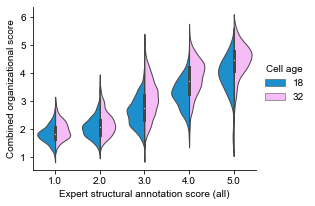

In [79]:
dims = (4,3)
fig, ax = plt.subplots(figsize=dims)

ax = sns.violinplot(
    data=df_org_scores_all,
    x="Expert structural annotation score (all)",
    y="Combined organizational score",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    split=True,
    linewidth=1
)

plt.legend(bbox_to_anchor=(1.0, 0.7), frameon=False, title="Cell age");
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_supp_org_score_hist_by_expert_score_and_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_supp_org_score_hist_by_expert_score_and_day.svg', format="svg", bbox_inches = "tight")

In [80]:
targets = [
    'BMPER (count/μm^2)',
    'CNTN5 (count/μm^2)',
    'MEF2C (count/μm^2)',
    'MYL7 (count/μm^2)',
    'NKX2 (count/μm^2)',
    'PLN (count/μm^2)',
    'PRSS35 (count/μm^2)',
    'VCAN (count/μm^2)',
    'HPRT1 (count/μm^2)',
    'COL2A1 (count/μm^2)',
    'H19 (count/μm^2)',
    'ATP2A2 (count/μm^2)',
    'MYH6 (count/μm^2)',
    'MYH7 (count/μm^2)',
    'BAG3 (count/μm^2)',
    'TCAP (count/μm^2)',
]

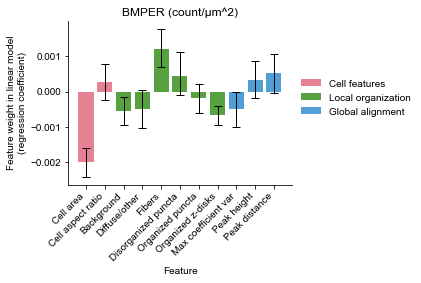

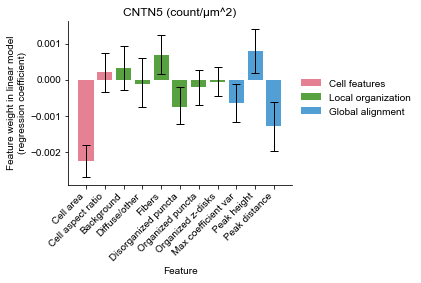

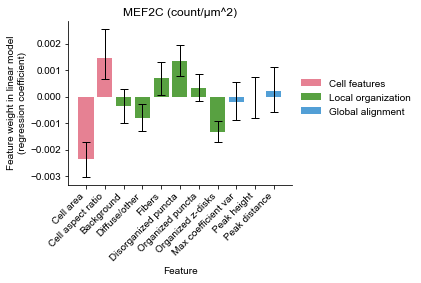

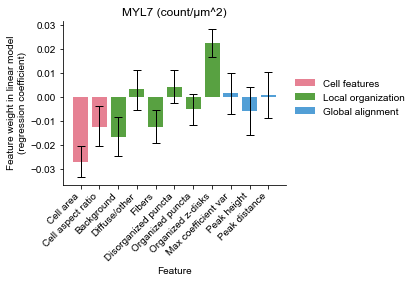

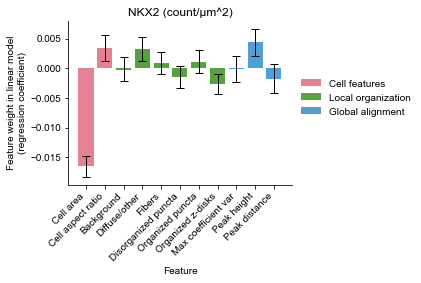

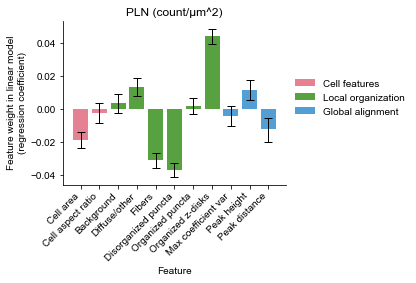

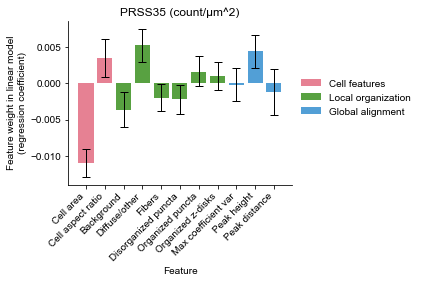

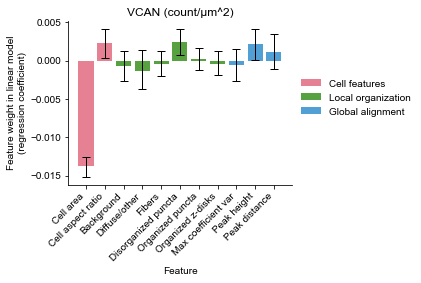

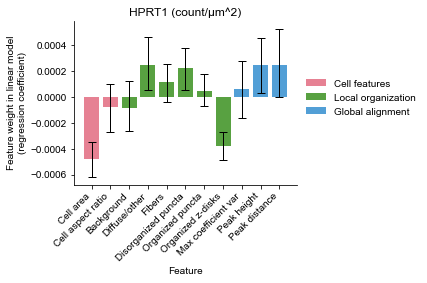

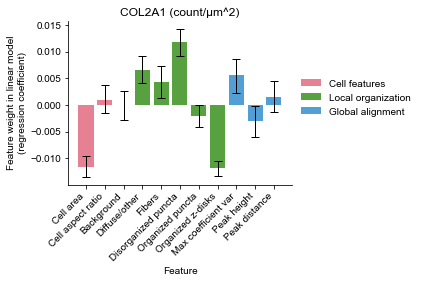

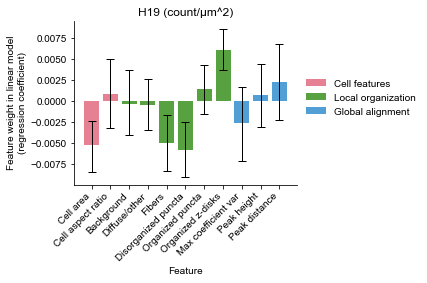

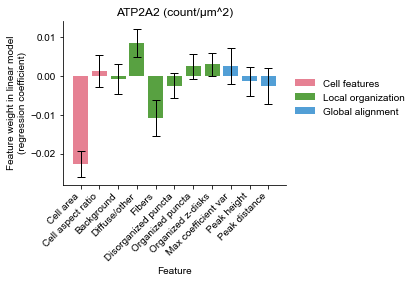

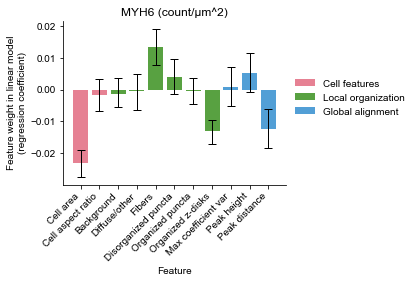

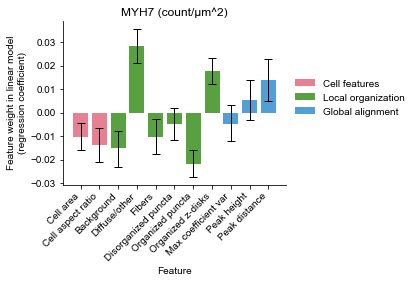

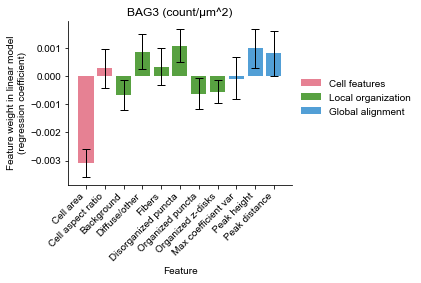

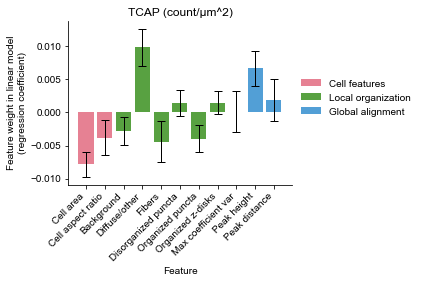

In [81]:
for target in targets:
    
    # bootstrapped regression
    df_boot_reg = boot_regression(
        df.dropna(subset=[target]).reset_index(drop=True),
        y_col=target,
        weight_col=None,
        N=1000
    )
    
    # get conf intervals from bootstrapped outputs
    reg_plot_ci_df = make_reg_plot_ci_df(df_boot_reg)
    
    # make the featue importance plot
    fig_bar, ax_bar = make_regression_bar_plot(reg_plot_ci_df, title=target)
    
    # save png and svg
    if SAVE:
        plt.savefig(regression_sup_dir_pngs/f'fig_supp_linear_model_feature_importances_{target.split()[0]}.png', dpi=100, bbox_inches = "tight")
        plt.savefig(regression_sup_dir_svgs/f'fig_supp_linear_model_feature_importances_{target.split()[0]}.svg', format="svg", bbox_inches = "tight")

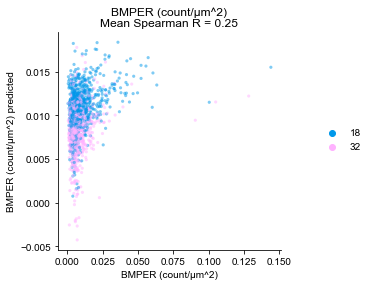

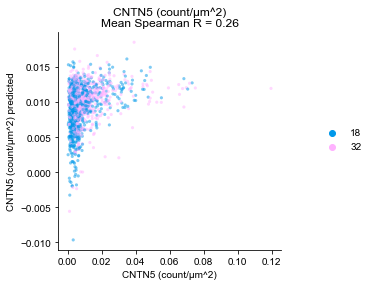

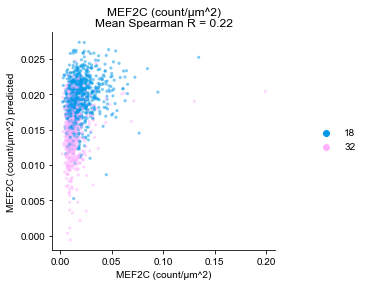

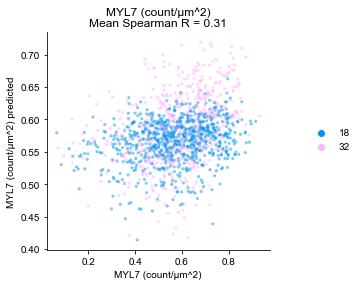

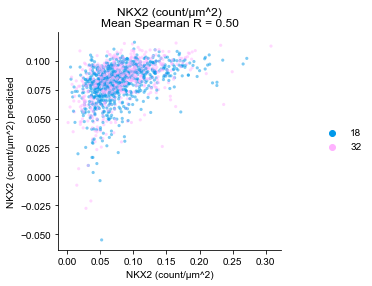

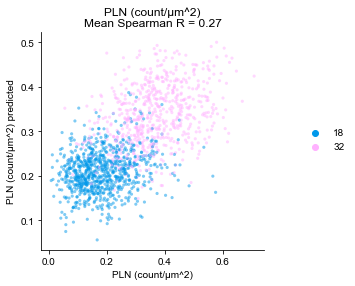

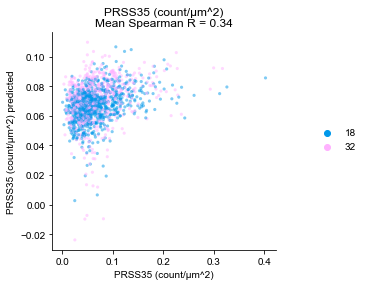

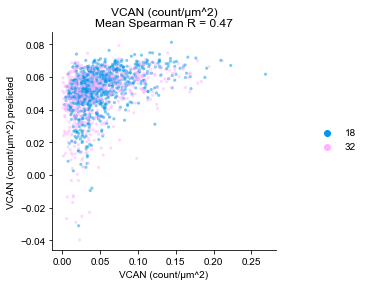

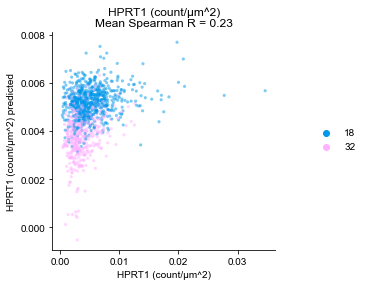

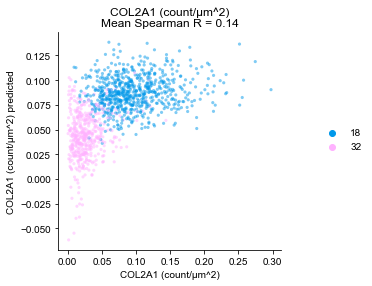

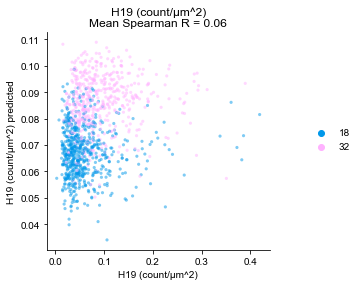

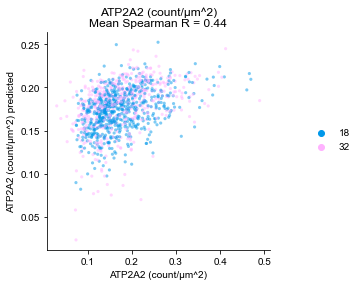

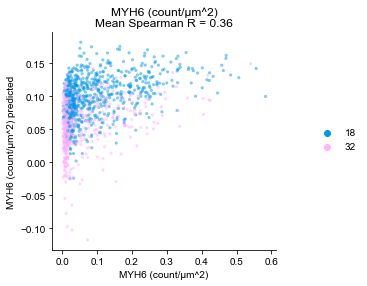

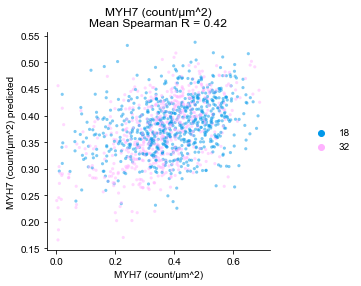

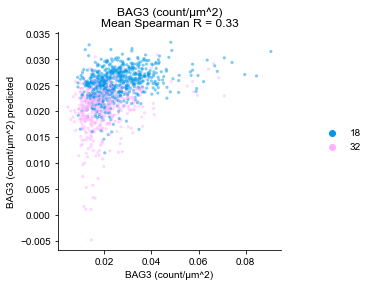

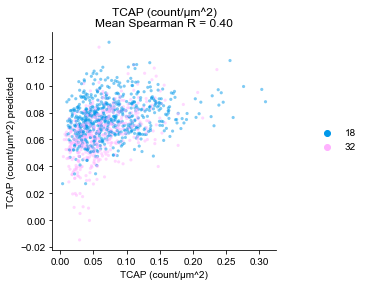

In [82]:
for target in targets:
    
    df_pred_true  = get_pred_true(
        df.dropna(subset=[target]).reset_index(drop=True),
        y_col=target,
        weight_col=None,
        meta_cols=["Cell age"]
    )
    
    spr = np.mean(
        [
            spearmanr(
                df_pred_true[df_pred_true["Cell age"]==day][target],
                df_pred_true[df_pred_true["Cell age"]==day][f'{target} predicted'])[0]
            for day in [18, 32]
        ]
    )

    title = f'{target.replace("_", " ")}\nMean Spearman R = {spr:.2f}'
    
    fig_scatter, ax_scatter = make_regression_scatter_plot(df_pred_true, target=target, title=title);

    # save png and svg
    if SAVE:
        plt.savefig(regression_sup_dir_pngs/f'fig_supp_linear_model_pred_acc_{target.split()[0]}.png', dpi=100, bbox_inches = "tight")
        plt.savefig(regression_sup_dir_svgs/f'fig_supp_linear_model_pred_acc_{target.split()[0]}.svg', format="svg", bbox_inches = "tight")

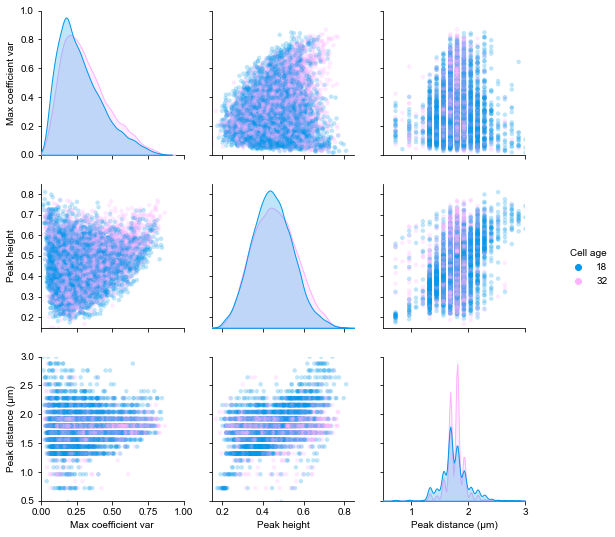

In [83]:
g = sns.pairplot(
    df.sample(frac=1, replace=False).reset_index(drop=True),
    x_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    y_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    hue='Cell age',
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    plot_kws=dict(
        linewidth=0,
        alpha = 0.25,
        s=20
    ),
    diag_kws=dict(
        bw_method=1, bw_adjust=0.15, common_norm=False
    )
);

mcv_lims = (0,1)
ph_lims = (0.15,0.85)
pd_lims = (0.5,3.0)

g.axes[0,0].set_xlim(mcv_lims)
g.axes[1,1].set_xlim(ph_lims)
g.axes[2,2].set_xlim(pd_lims)

g.axes[0,1].set_xlim(ph_lims)
g.axes[0,1].set_ylim(mcv_lims)
g.axes[1,0].set_xlim(mcv_lims)
g.axes[1,0].set_ylim(ph_lims)

g.axes[0,2].set_xlim(pd_lims)
g.axes[0,2].set_ylim(mcv_lims)
g.axes[2,0].set_xlim(mcv_lims)
g.axes[2,0].set_ylim(pd_lims)

g.axes[1,2].set_xlim(pd_lims)
g.axes[1,2].set_ylim(ph_lims)
g.axes[2,1].set_xlim(ph_lims)
g.axes[2,1].set_ylim(pd_lims);

plt.subplots_adjust(hspace=0.2, wspace=0.2)
g._legend.set_bbox_to_anchor((1.05, 0.5))

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f'fig_supp_global_alignment_correlations_day.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'fig_supp_global_alignment_correlations_day.svg', format="svg", bbox_inches = "tight")

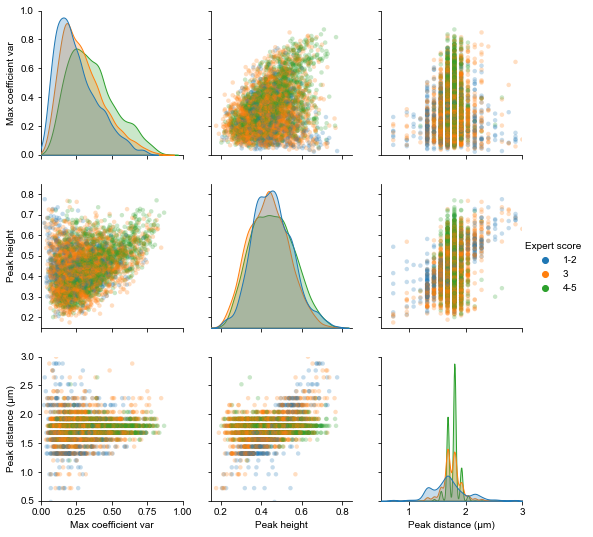

In [84]:
g = sns.pairplot(
    df.sample(frac=1, replace=False).reset_index(drop=True),
    x_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    y_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    hue="Expert structural annotation score (grouped)",
    hue_order=["1-2", "3", "4-5"],
    aspect=1,
    plot_kws=dict(
        linewidth=0,
        alpha = 0.25,
        s=20
    ),
    diag_kws=dict(
        bw_method=1, bw_adjust=0.2, common_norm=False
    )
);

mcv_lims = (0,1)
ph_lims = (0.15,0.85)
pd_lims = (0.5,3.0)

g.axes[0,0].set_xlim(mcv_lims)
g.axes[1,1].set_xlim(ph_lims)
g.axes[2,2].set_xlim(pd_lims)

g.axes[0,1].set_xlim(ph_lims)
g.axes[0,1].set_ylim(mcv_lims)
g.axes[1,0].set_xlim(mcv_lims)
g.axes[1,0].set_ylim(ph_lims)

g.axes[0,2].set_xlim(pd_lims)
g.axes[0,2].set_ylim(mcv_lims)
g.axes[2,0].set_xlim(mcv_lims)
g.axes[2,0].set_ylim(pd_lims)

g.axes[1,2].set_xlim(pd_lims)
g.axes[1,2].set_ylim(ph_lims)
g.axes[2,1].set_xlim(ph_lims)
g.axes[2,1].set_ylim(pd_lims);

plt.subplots_adjust(hspace=0.2, wspace=0.2)
g._legend.set_bbox_to_anchor((0.8, 0.5))
g._legend.set_title("Expert score  ")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f'fig_supp_global_alignment_correlations_score.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'fig_supp_global_alignment_correlations_score.svg', format="svg", bbox_inches = "tight")

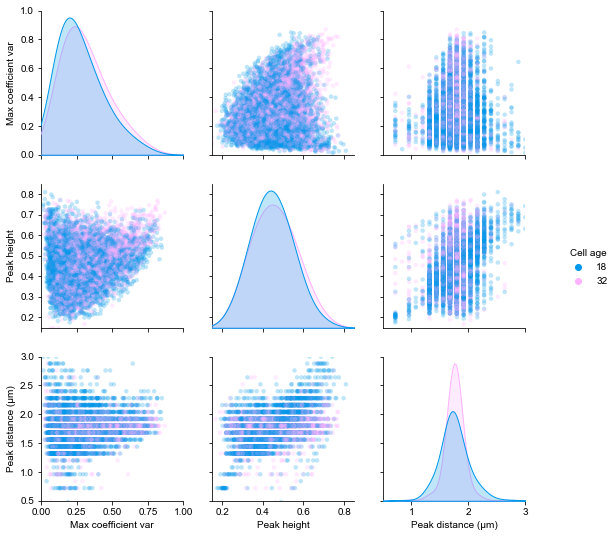

In [85]:
g = sns.pairplot(
    df.sample(frac=1, replace=False).reset_index(drop=True),
    x_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    y_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    hue='Cell age',
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    plot_kws=dict(
        linewidth=0,
        alpha = 0.25,
        s=20
    ),
    diag_kws=dict(
        bw_method=1, bw_adjust=0.5, common_norm=False
    )
);

mcv_lims = (0,1)
ph_lims = (0.15,0.85)
pd_lims = (0.5,3.0)

g.axes[0,0].set_xlim(mcv_lims)
g.axes[1,1].set_xlim(ph_lims)
g.axes[2,2].set_xlim(pd_lims)

g.axes[0,1].set_xlim(ph_lims)
g.axes[0,1].set_ylim(mcv_lims)
g.axes[1,0].set_xlim(mcv_lims)
g.axes[1,0].set_ylim(ph_lims)

g.axes[0,2].set_xlim(pd_lims)
g.axes[0,2].set_ylim(mcv_lims)
g.axes[2,0].set_xlim(mcv_lims)
g.axes[2,0].set_ylim(pd_lims)

g.axes[1,2].set_xlim(pd_lims)
g.axes[1,2].set_ylim(ph_lims)
g.axes[2,1].set_xlim(ph_lims)
g.axes[2,1].set_ylim(pd_lims);

plt.subplots_adjust(hspace=0.2, wspace=0.2)
g._legend.set_bbox_to_anchor((1.05, 0.5))

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f'fig_supp_global_alignment_correlations_day_smoother.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'fig_supp_global_alignment_correlations_day_smoother.svg', format="svg", bbox_inches = "tight")

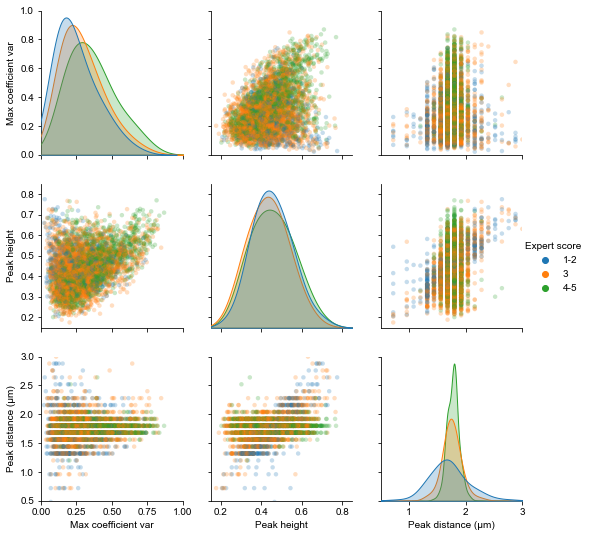

In [86]:
g = sns.pairplot(
    df.sample(frac=1, replace=False).reset_index(drop=True),
    x_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    y_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    hue="Expert structural annotation score (grouped)",
    hue_order=["1-2", "3", "4-5"],
    aspect=1,
    plot_kws=dict(
        linewidth=0,
        alpha = 0.25,
        s=20
    ),
    diag_kws=dict(
        bw_method=1, bw_adjust=0.5, common_norm=False
    )
);

mcv_lims = (0,1)
ph_lims = (0.15,0.85)
pd_lims = (0.5,3.0)

g.axes[0,0].set_xlim(mcv_lims)
g.axes[1,1].set_xlim(ph_lims)
g.axes[2,2].set_xlim(pd_lims)

g.axes[0,1].set_xlim(ph_lims)
g.axes[0,1].set_ylim(mcv_lims)
g.axes[1,0].set_xlim(mcv_lims)
g.axes[1,0].set_ylim(ph_lims)

g.axes[0,2].set_xlim(pd_lims)
g.axes[0,2].set_ylim(mcv_lims)
g.axes[2,0].set_xlim(mcv_lims)
g.axes[2,0].set_ylim(pd_lims)

g.axes[1,2].set_xlim(pd_lims)
g.axes[1,2].set_ylim(ph_lims)
g.axes[2,1].set_xlim(ph_lims)
g.axes[2,1].set_ylim(pd_lims);

plt.subplots_adjust(hspace=0.2, wspace=0.2)
g._legend.set_bbox_to_anchor((0.8, 0.5))
g._legend.set_title("Expert score  ")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f'fig_supp_global_alignment_correlations_score_smoother.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'fig_supp_global_alignment_correlations_score_smoother.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

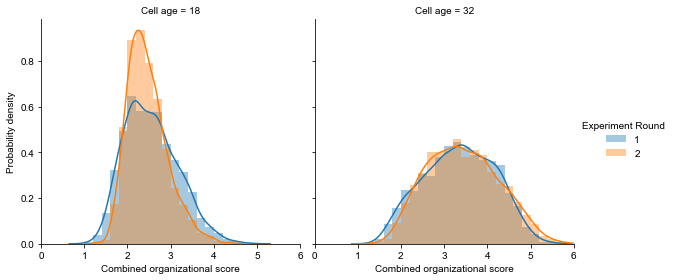

In [87]:
bins = np.linspace(0,6,31)

g = sns.FacetGrid(
    df,
    hue='Experiment Round',
    col='Cell age',
#     hue_order=[18, 32],
#     palette=DAY_COLOR_PALETTE,
    height=4
)
g = g.map(
    sns.distplot,
    'Combined organizational score',
    bins=bins
).add_legend()

g.set(
    xlim=(0, 6),
    ylabel='Probability density'
);

# # save png and svg
# if SAVE:
#     plt.savefig(save_dir_pngs/'fig_4f_linear_model_distplot_grouped_by_day.png', dpi=100, bbox_inches = "tight")
#     plt.savefig(save_dir_svgs/'fig_4f_linear_model_distplot_grouped_by_day.svg', format="svg", bbox_inches = "tight")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

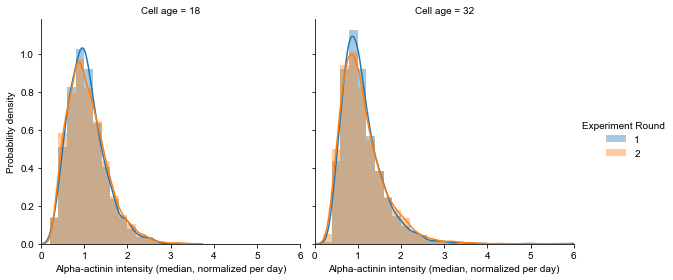

In [88]:
bins = np.linspace(0,6,31)

g = sns.FacetGrid(
    df,
    hue='Experiment Round',
    col='Cell age',
#     hue_order=[18, 32],
#     palette=DAY_COLOR_PALETTE,
    height=4
)
g = g.map(
    sns.distplot,
    "Alpha-actinin intensity (median, normalized per day)",
    bins=bins
).add_legend()

g.set(
    xlim=(0, 6),
    ylabel='Probability density'
);

# # save png and svg
# if SAVE:
#     plt.savefig(save_dir_pngs/'fig_4f_linear_model_distplot_grouped_by_day.png', dpi=100, bbox_inches = "tight")
#     plt.savefig(save_dir_svgs/'fig_4f_linear_model_distplot_grouped_by_day.svg', format="svg", bbox_inches = "tight")

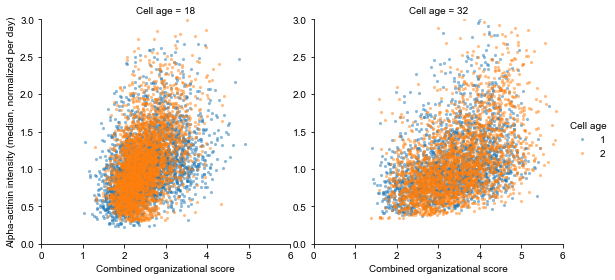

In [89]:
g = sns.FacetGrid(
    df,
    hue='Experiment Round',
#     hue_order=[18, 32],
#     palette=DAY_COLOR_PALETTE,
    height=4,
    aspect=1,
    col="Cell age",
    sharey=False,
)
g = g.map(
    sns.scatterplot,
    "Combined organizational score",
    "Alpha-actinin intensity (median, normalized per day)",
    linewidth=0,
    alpha = 0.5,
    s=10,
).add_legend(title='Cell age')

axes = g.axes[0];
axes[0].set_ylim(0, 3);
axes[1].set_ylim(0, 3);
axes[0].set_xlim(0, 6);
axes[1].set_xlim(0, 6);

g.set_titles("Cell age = {col_name}")

# # save png and svg
# if SAVE:
#     plt.savefig(save_dir_pngs/'fig_4g_linear_model_org_vs_actn2_medain_intensity.png', dpi=100, bbox_inches = "tight")
#     plt.savefig(save_dir_svgs/'fig_4g_linear_model_org_vs_actn2_medain_intensity.svg', format="svg", bbox_inches = "tight")

In [90]:
df_boot_reg

Cell area (μm^2)  Cell aspect ratio  Fraction cell area background  \
0           -0.007702          -0.003490                      -0.002495   
1           -0.007793          -0.004708                      -0.001833   
2           -0.006932          -0.004786                      -0.001129   
3           -0.007377          -0.004934                      -0.004234   
4           -0.007594          -0.001309                      -0.005191   
..                ...                ...                            ...   
995         -0.007425          -0.001333                      -0.001383   
996         -0.008441          -0.005577                      -0.002761   
997         -0.007418          -0.004543                      -0.002597   
998         -0.007959          -0.002659                      -0.002720   
999         -0.008082          -0.001788                      -0.001717   

     Fraction cell area diffuse/other  Fraction cell area fibers  \
0                            0.010712                  -0.004538   
1                            0.008131                  -0.002706   
2                            0.010196                  -0.003209   
3                            0.009657                  -0.005325   
4                            0.010188                  -0.004849   
..                                ...                        ...   
995                          0.010813                  -0.003373   
996                          0.010210                  -0.004667   
997                          0.009755                  -0.004735   
998                          0.007610                  -0.003915   
999                          0.009312                  -0.004254   

     Fraction cell area disorganized puncta  \
0                                  0.000116   
1                                  0.004467   
2                                  0.000841   
3                                  0.001804   
4                                  0.000371   
..                                      ...   
995                               -0.000613   
996                                0.002539   
997                                0.000689   
998                                0.002179   
999                                0.002369   

     Fraction cell area organized puncta  \
0                              -0.003784   
1                              -0.005657   
2                              -0.004971   
3                              -0.002585   
4                              -0.001637   
..                                   ...   
995                            -0.004310   
996                            -0.004032   
997                            -0.003511   
998                            -0.004959   
999                            -0.005241   

     Fraction cell area organized z-disks  Max coefficient var  Peak height  \
0                                0.001208             0.001056     0.003373   
1                                0.001163            -0.000657     0.006660   
2                                0.000296             0.000467     0.006400   
3                                0.001389            -0.000646     0.009738   
4                                0.000663            -0.002629     0.010648   
..                                    ...                  ...          ...   
995                              0.000649             0.002411     0.007535   
996                              0.000983             0.000626     0.006771   
997                              0.001824            -0.001124     0.007392   
998                              0.002842            -0.000848     0.006411   
999                              0.002295             0.000664     0.007071   

     Peak distance (μm)  
0              0.002035  
1              0.001774  
2              0.002243  
3              0.000576  
4              0.001740  
..                  ...  
995            0.000565  
996            0.000689  
997       

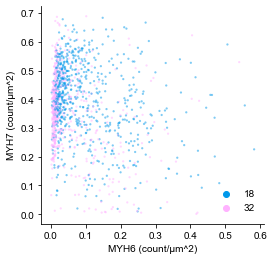

In [91]:
dims = (4,4)
fig, ax = plt.subplots(figsize=dims)
g = sns.scatterplot(
    data=df.sample(frac=1, replace=False).reset_index(drop=True),
    x='MYH6 (count/μm^2)',
    y='MYH7 (count/μm^2)',
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    s=5,
    alpha=0.5,
    linewidth=0,
)
# g.set(xlim=(0,10_000));

plt.legend(bbox_to_anchor=(1.0, 0.2), frameon=False)
sns.despine();

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_supp_myh6_vs_myh7.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_supp_myh6_vs_myh7.svg', format="svg", bbox_inches = "tight")

## Regression ablation

In [92]:
df_r1 = df[df['Experiment Round'] == 1]
SCORE_COLUMNS = ["Expert structural annotation score (mean)", "Combined organizational score"]
df_r1_reg = df[BAR_PLOT_COLUMNS + SCORE_COLUMNS]

In [93]:
from sklearn import linear_model
from sklearn.preprocessing import scale

def regress(
    data=pd.DataFrame(),
    y_col='Expert structural annotation score (mean)',
    X_cols=[
        'Cell area (μm^2)',
        'Cell aspect ratio',
        'Fraction cell area background',
        'Fraction cell area diffuse/other',
        'Fraction cell area fibers',
        'Fraction cell area disorganized puncta',
        'Fraction cell area organized puncta',
        'Fraction cell area organized z-disks',
        'Max coefficient var',
        'Peak height',
        'Peak distance (μm)',
    ],
    scale_factors=None,
    weight_col=None,
    alpha=0.001,
):
    X = data[X_cols]
    if scale_factors is not None:
        
    y = data[y_col]

    if weight_col is not None:
        class_weights = {
            v: len(y) / c for v, c in zip(*np.unique(y, return_counts=True))
        }
        sample_weights = df[y_col].map(class_weights)
    else:
        sample_weights = 1

    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(X, y, sample_weight=sample_weights)
    
    return reg, scale_factors

IndentationError: expected an indented block (<ipython-input-93-ea2ee7a0aaa7>, line 27)

In [ ]:
df_r1_scaled = df_r1[BAR_PLOT_COLUMNS + SCORE_COLUMNS].copy()
df_r1_scaled[BAR_PLOT_COLUMNS] = scale(df_r1_scaled[BAR_PLOT_COLUMNS])

In [ ]:
scaler = StandardScaler()
scaler.fit()

In [94]:
BAR_PLOT_COLUMNS

['Cell area (μm^2)',
 'Cell aspect ratio',
 'Fraction cell area background',
 'Fraction cell area diffuse/other',
 'Fraction cell area fibers',
 'Fraction cell area disorganized puncta',
 'Fraction cell area organized puncta',
 'Fraction cell area organized z-disks',
 'Max coefficient var',
 'Peak height',
 'Peak distance (μm)']